In [1]:
import sys
import os
# hardcodeo de paths
sys.path.append(os.path.dirname(os.path.abspath('')))
dataset_dir = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'datasets')

import pickle
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
import seaborn as sns         
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [71]:
#image_dir = '/home/magickmichelle/Documentos/maestria2020_2021/taller_tesis/137/linea_137_llamados_vs/images'

In [2]:
#llamados= pd.read_excel(os.path.join(dataset_dir, 'xlsx/llamados_group_I.xlsx'))
#llamados.head()

In [17]:
dataset_dir = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'datasets')
#llamados_v2= pd.read_excel(os.path.join(dataset_dir, 'xlsx/llamados_v2.xlsx'), parse_dates=['llamado_fecha_hora'])
llamados= pd.read_excel(os.path.join(dataset_dir, 'xlsx/llamados_v2.xlsx'))

In [3]:
# droppear las variables que están agrupadas en otras, fecha y hora separadas y provincia id

llamados.drop(['vs_explotacion_sexual','vs_explotacion_sexual_comercial','vs_explotacion_sexual_viajes_turismo',
              'vs_sospecha_trata_personas_fines_sexuales', 'vs_violacion_via_vaginal', 'vs_violacion_via_anal', 
               'vs_violacion_via_oral', 'ofv_uso_arma_blanca','ofv_uso_arma_fuego', 'ofv_intento_ahorcar', 
               'ofv_intento_quemar', 'ofv_intento_ahogar','ofv_intento_matar', 'llamado_fecha', 'llamado_hora',
              'llamado_provincia_id'], axis=1, inplace=True)

In [4]:
# corregir nombres de columnas (TO DO: pasar al pipeline de agrupación luego)

llamados.rename(columns={"ofv_uso_arma": "ofv_uso_arma_group", "ofv_intento_violencia_fisica": "ofv_intento_violencia_fisica_group"}, inplace=True)
#llamados.columns

In [77]:
llamados.llamante_vinculo

array(['Hospital', 'Madre', 'Víctima', 'Vecina/o', 'Padre', 'Agresor/a',
       'Familiar', 'Otro conocido', 'Abuela/o', 'Otra Institución',
       'NS/NC', 'Comisaría', 'Escuela', 'Hermana/o', 'Defensoría',
       'Otra institución'], dtype=object)

In [72]:
(llamados.llamante_edad.isnull().sum()/llamados.shape[0])*100

44.820561040589254

In [71]:
(llamados.victima_edad.isnull().sum()/llamados.shape[0])*100

9.820822232669906

In [79]:
(llamados.vinculo_llam_group == 'Institución').sum()
#DE ESOS, 3651 NO DA LA EDAD

5615

In [ ]:
llamados.isnull().sum()

# llamante_edad                                8580
# victima_edad                                  1880

"One useful way to explore the relationship between a continuous and a categorical variable is with a set of side by side box plots, one for each of the categories. Similarities and differences between the category levels can be seen in the length and position of the boxes and whiskers." https://sscc.wisc.edu/sscc/pubs/DWE/book/3-3-sect-ggplot-categorical.html

Los datos faltantes pueden estar en edad de victima, edad de llamante o en ambos. Armo diferentes filtros para tener todas las combinaciones de estados de los datos en edad de víctima y llamante. 

### variables_interes 

victima_discapacidad, victima_a_resguardo, 
victima_convive_agresor, 
llamante_genero, 
victima_genero, 
llamante_vinculo, 
victima_vinculo_agresor,
hecho_lugar 

### variables de interés construidas 
genero_del_agresor, conoce_victima_agresor, vinculo_llam_group, vinculo_agresor (reducido)



### datasets según filtros

llamados, null_victima_edad,null_llamante_edad, null_edades,
completo_victima_edad, completo_edades, completo_llamante_edad, v_lleno_ll_vacio_edades, v_vacio_ll_lleno_edades  

In [18]:
# construyo agresor_fam_no_fam

lista_familiar = ['Abuela', 'Abuelo', 'Hermana', 'Hermano', 'Madrastra', 'Madre', 'Otro pariente', 'Padrastro', 'Padre', 'Tío' ]
lista_no_familiar = ['Desconocido', 'Conocido no familiar (Amigo, vecino, entre otros)']
lista_pareja_exp = ['Pareja de la víctima', 'Ex pareja de la víctima']

def columna_fam_nofam (x):
    if x in lista_familiar:
        return 'Familiar'
    elif x in lista_no_familiar:
        return 'No Familiar'
    elif x in lista_pareja_exp:
        return 'Pareja/Ex'
    elif x == 'NS/NC':
        return x
    else:
        return 'N/A'

    
llamados['agresor_fam_no_fam'] = \
    llamados.victima_vinculo_agresor.apply(columna_fam_nofam)

In [19]:
# construyo genero agresor

# género dell agresor
lista_hombre = [ 'Abuelo', 'Hermano', 'Padrastro', 'Padre', 'Tío' ]
lista_mujer = [ 'Abuela','Hermana','Madrastra', 'Madre']
lista_no_especificado = ['Ex pareja de la víctima','Pareja de la víctima', 
                                   'Otro pariente','Conocido no familiar (Amigo, vecino, entre otros)', 'Desconocido']

def columna_genero_agresor (x):
    if x in lista_mujer:
        return 'Femenino'
    elif x in lista_hombre:
        return 'Masculino'
    elif x in lista_no_especificado:
        return 'No especificado'
    elif x == 'NS/NC':
        return x
    else:
        return 'N/A'

llamados['genero_agresor'] = \
    llamados.victima_vinculo_agresor.apply(columna_genero_agresor)


In [20]:
# construyo conoce victima agresor

lista_conocido = ['Abuela', 'Abuelo','Pareja de la víctima', 'Ex pareja de la víctima', 'Conocido no familiar (Amigo, vecino, entre otros)', 'Hermana', 'Hermano', 'Madrastra', 'Madre', 'Otro pariente', 'Padrastro', 'Padre', 'Tío' ]
lista_no_conocido = ['Desconocido', ]
lista_no_declarado = ['NS/NC']

def columna_conocido_no_conocido (x):
    if x in lista_conocido:
        return 'Agresor conocido'
    elif x in lista_no_conocido:
        return 'Agresor desconocido'
    elif x in lista_no_declarado:
        return 'NS/NC'
    else:
        return 'N/A'

llamados['agresor_conocido_no_conocido'] = \
    llamados.victima_vinculo_agresor.apply(columna_conocido_no_conocido)


In [21]:
# construyo vinculo_llam_group

lista_institucion = ['Hospital', 'Comisaría', 'Escuela', 'Defensoría', 'Otra Institución', 'Otra institución']
lista_conocide = ['Madre', 'Vecina/o', 'Padre', 'Familiar', 'Otro conocido', 'Abuela/o','Hermana/o']

################################################### OJO con esto
def vinculo_llamante (x):
    if x in lista_institucion:
        return 'Institución'
    elif x in lista_conocide:
        return 'Conocido (fam/no fam)'
    elif x == 'NS/NC':
        return x
    elif x == 'Víctima':
        return x
    elif x == 'Agresor/a':
        return x
    else:
        return 'N/A'
    
    
llamados['vinculo_llam_group'] = \
    llamados.llamante_vinculo.apply(vinculo_llamante)

In [19]:
#llamados.columns

In [22]:
# combinaciones con datos faltantes:

# v_mezclado ll_mezclado: llamados

# v_vacio ll_mezclado: null_victima_edad
null_victima_edad = llamados[llamados['victima_edad'].isnull()]

# ll_vacio v_mezclado: null_llamante_edad
null_llamante_edad = llamados[llamados['llamante_edad'].isnull()]

# v_vacio ll_vacio: null_edaddes
null_edades = llamados[(llamados['victima_edad'].isnull()) & (llamados['llamante_edad'].isnull())]

# v_lleno ll_mezclado: completo_victima_edad
completo_victima_edad = llamados[~(llamados['victima_edad'].isnull())]

# v_mezclado ll_lleno: completo_llamante_edad
completo_llamante_edad = llamados[~(llamados['llamante_edad'].isnull())]

# v_lleno ll_lleno: completo_edades
completo_edades = llamados[~(llamados['victima_edad'].isnull()) & ~(llamados['llamante_edad'].isnull())]

# v_lleno ll_vacio: v_lleno_ll_vacio_edades

v_lleno_ll_vacio_edades= llamados[~(llamados['victima_edad'].isnull()) & (llamados['llamante_edad'].isnull())] 

# v_vacio ll_lleno: v_vacio_ll_lleno_edades

v_vacio_ll_lleno_edades= llamados[(llamados['victima_edad'].isnull()) & ~(llamados['llamante_edad'].isnull())]


In [23]:
# Calculate the normalized counts of each varaible agresor_fam_no_fam


# agresor_fam_no_fam

agresor_llamados_counts = llamados['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_null_victima_edad_counts = null_victima_edad['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_null_llamante_edad_counts = null_llamante_edad['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_null_edades_counts = null_edades['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_completo_victima_edad_counts = completo_victima_edad['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_completo_llamante_edad_counts = completo_llamante_edad['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_completo_edades_counts = completo_edades['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['agresor_fam_no_fam'].value_counts(normalize=True)
agresor_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['agresor_fam_no_fam'].value_counts(normalize=True)


# victima_discapacidad

llamados_counts = llamados['victima_discapacidad'].value_counts(normalize=True)
null_victima_edad_counts = null_victima_edad['victima_discapacidad'].value_counts(normalize=True)
null_llamante_edad_counts = null_llamante_edad['victima_discapacidad'].value_counts(normalize=True)
null_edades_counts = null_edades['victima_discapacidad'].value_counts(normalize=True)
completo_victima_edad_counts = completo_victima_edad['victima_discapacidad'].value_counts(normalize=True)
completo_llamante_edad_counts = completo_llamante_edad['victima_discapacidad'].value_counts(normalize=True)
completo_edades_counts = completo_edades['victima_discapacidad'].value_counts(normalize=True)
v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['victima_discapacidad'].value_counts(normalize=True)
v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['victima_discapacidad'].value_counts(normalize=True)



# victima_a_resguardo

resguardo_llamados_counts = llamados['victima_a_resguardo'].value_counts(normalize=True)
resguardo_null_victima_edad_counts = null_victima_edad['victima_a_resguardo'].value_counts(normalize=True)
resguardo_null_llamante_edad_counts = null_llamante_edad['victima_a_resguardo'].value_counts(normalize=True)
resguardo_null_edades_counts = null_edades['victima_a_resguardo'].value_counts(normalize=True)
resguardo_completo_victima_edad_counts = completo_victima_edad['victima_a_resguardo'].value_counts(normalize=True)
resguardo_completo_llamante_edad_counts = completo_llamante_edad['victima_a_resguardo'].value_counts(normalize=True)
resguardo_completo_edades_counts = completo_edades['victima_a_resguardo'].value_counts(normalize=True)
resguardo_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['victima_a_resguardo'].value_counts(normalize=True)
resguardo_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['victima_a_resguardo'].value_counts(normalize=True)


# victima_convive_agresor
convive_llamados_counts = llamados['victima_convive_agresor'].value_counts(normalize=True)
convive_null_victima_edad_counts = null_victima_edad['victima_convive_agresor'].value_counts(normalize=True)
convive_null_llamante_edad_counts = null_llamante_edad['victima_convive_agresor'].value_counts(normalize=True)
convive_null_edades_counts = null_edades['victima_convive_agresor'].value_counts(normalize=True)
convive_completo_victima_edad_counts = completo_victima_edad['victima_convive_agresor'].value_counts(normalize=True)
convive_completo_llamante_edad_counts = completo_llamante_edad['victima_convive_agresor'].value_counts(normalize=True)
convive_completo_edades_counts = completo_edades['victima_convive_agresor'].value_counts(normalize=True)
convive_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['victima_convive_agresor'].value_counts(normalize=True)
convive_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['victima_convive_agresor'].value_counts(normalize=True)

# llamante_genero
llgenero_llamados_counts = llamados['llamante_genero'].value_counts(normalize=True)
llgenero_null_victima_edad_counts = null_victima_edad['llamante_genero'].value_counts(normalize=True)
llgenero_null_llamante_edad_counts = null_llamante_edad['llamante_genero'].value_counts(normalize=True)
llgenero_null_edades_counts = null_edades['llamante_genero'].value_counts(normalize=True)
llgenero_completo_victima_edad_counts = completo_victima_edad['llamante_genero'].value_counts(normalize=True)
llgenero_completo_llamante_edad_counts = completo_llamante_edad['llamante_genero'].value_counts(normalize=True)
llgenero_completo_edades_counts = completo_edades['llamante_genero'].value_counts(normalize=True)
llgenero_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['llamante_genero'].value_counts(normalize=True)
llgenero_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['llamante_genero'].value_counts(normalize=True)


# victima_genero
vgenero_llamados_counts = llamados['victima_genero'].value_counts(normalize=True)
vgenero_null_victima_edad_counts = null_victima_edad['victima_genero'].value_counts(normalize=True)
vgenero_null_llamante_edad_counts = null_llamante_edad['victima_genero'].value_counts(normalize=True)
vgenero_null_edades_counts = null_edades['victima_genero'].value_counts(normalize=True)
vgenero_completo_victima_edad_counts = completo_victima_edad['victima_genero'].value_counts(normalize=True)
vgenero_completo_llamante_edad_counts = completo_llamante_edad['victima_genero'].value_counts(normalize=True)
vgenero_completo_edades_counts = completo_edades['victima_genero'].value_counts(normalize=True)
vgenero_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['victima_genero'].value_counts(normalize=True)
vgenero_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['victima_genero'].value_counts(normalize=True)


# llamante_vinculo
llvinculo_llamados_counts = llamados['llamante_vinculo'].value_counts(normalize=True)
llvinculo_null_victima_edad_counts = null_victima_edad['llamante_vinculo'].value_counts(normalize=True)
llvinculo_null_llamante_edad_counts = null_llamante_edad['llamante_vinculo'].value_counts(normalize=True)
llvinculo_null_edades_counts = null_edades['llamante_vinculo'].value_counts(normalize=True)
llvinculo_completo_victima_edad_counts = completo_victima_edad['llamante_vinculo'].value_counts(normalize=True)
llvinculo_completo_llamante_edad_counts = completo_llamante_edad['llamante_vinculo'].value_counts(normalize=True)
llvinculo_completo_edades_counts = completo_edades['llamante_vinculo'].value_counts(normalize=True)
llvinculo_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['llamante_vinculo'].value_counts(normalize=True)
llvinculo_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['llamante_vinculo'].value_counts(normalize=True)

# victima_vinculo_agresor
agvinculo_llamados_counts = llamados['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_null_victima_edad_counts = null_victima_edad['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_null_llamante_edad_counts = null_llamante_edad['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_null_edades_counts = null_edades['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_completo_victima_edad_counts = completo_victima_edad['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_completo_llamante_edad_counts = completo_llamante_edad['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_completo_edades_counts = completo_edades['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['victima_vinculo_agresor'].value_counts(normalize=True)
agvinculo_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['victima_vinculo_agresor'].value_counts(normalize=True)


# hecho_lugar
lugar_llamados_counts = llamados['hecho_lugar'].value_counts(normalize=True)
lugar_null_victima_edad_counts = null_victima_edad['hecho_lugar'].value_counts(normalize=True)
lugar_null_llamante_edad_counts = null_llamante_edad['hecho_lugar'].value_counts(normalize=True)
lugar_null_edades_counts = null_edades['hecho_lugar'].value_counts(normalize=True)
lugar_completo_victima_edad_counts = completo_victima_edad['hecho_lugar'].value_counts(normalize=True)
lugar_completo_llamante_edad_counts = completo_llamante_edad['hecho_lugar'].value_counts(normalize=True)
lugar_completo_edades_counts = completo_edades['hecho_lugar'].value_counts(normalize=True)
lugar_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['hecho_lugar'].value_counts(normalize=True)
lugar_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['hecho_lugar'].value_counts(normalize=True)

# genero_agresor

genagr_llamados_counts = llamados['genero_agresor'].value_counts(normalize=True)
genagr_null_victima_edad_counts = null_victima_edad['genero_agresor'].value_counts(normalize=True)
genagr_null_llamante_edad_counts = null_llamante_edad['genero_agresor'].value_counts(normalize=True)
genagr_null_edades_counts = null_edades['genero_agresor'].value_counts(normalize=True)
genagr_completo_victima_edad_counts = completo_victima_edad['genero_agresor'].value_counts(normalize=True)
genagr_completo_llamante_edad_counts = completo_llamante_edad['genero_agresor'].value_counts(normalize=True)
genagr_completo_edades_counts = completo_edades['genero_agresor'].value_counts(normalize=True)
genagr_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['genero_agresor'].value_counts(normalize=True)
genagr_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['genero_agresor'].value_counts(normalize=True)


# agresor conocido_no_conocido

agr_con_nc_llamados_counts = llamados['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_null_victima_edad_counts = null_victima_edad['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_null_llamante_edad_counts = null_llamante_edad['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_null_edades_counts = null_edades['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_completo_victima_edad_counts = completo_victima_edad['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_completo_llamante_edad_counts = completo_llamante_edad['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_completo_edades_counts = completo_edades['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['agresor_conocido_no_conocido'].value_counts(normalize=True)
agr_con_nc_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['agresor_conocido_no_conocido'].value_counts(normalize=True)



# vinculo_llam_group

vinc_llam_gr_llamados_counts = llamados['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_null_victima_edad_counts = null_victima_edad['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_null_llamante_edad_counts = null_llamante_edad['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_null_edades_counts = null_edades['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_completo_victima_edad_counts = completo_victima_edad['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_completo_llamante_edad_counts = completo_llamante_edad['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_completo_edades_counts = completo_edades['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_v_lleno_ll_vacio_edades_counts = v_lleno_ll_vacio_edades['vinculo_llam_group'].value_counts(normalize=True)
vinc_llam_gr_v_vacio_ll_lleno_edades_counts = v_vacio_ll_lleno_edades['vinculo_llam_group'].value_counts(normalize=True)


In [22]:
# todos estos son tests. To do: convertir esto en tests 


'''llamados.vinculo_llam_group.unique() 
tiene que dar: array(['Institución', 'Conocido (fam/no fam)', 'Víctima', 'Agresor/a',
       'NS/NC'], dtype=object)

llamados.genero_agresor.unique()
tiene que dar: array(['Masculino', 'Femenino', 'No especificado', 'NS/NC'], dtype=object)

llamados.agresor_conocido_no_conocido.unique()
tiene que dar: array(['Agresor conocido por víctima', 'NS/NC',
       'Agresor no conocido por víctima'], dtype=object)
       

llamados.agresor_fam_no_fam.unique()
tiene que dar: array(['Familiar', 'No Familiar', 'NS/NC', 'Pareja/Ex'], dtype=object)


'''


array(['Institución', 'Conocido (fam/no fam)', 'Víctima', 'Agresor/a',
       'NS/NC'], dtype=object)

In [13]:
llamados.agresor_fam_no_fam.unique()

array(['Familiar', 'No Familiar', 'NS/NC', 'Pareja/Ex'], dtype=object)

In [24]:
# paleta

palette_sino =sns.color_palette("husl", 2)

palette_gen = {"Masculino": "#726da8", "Femenino": "#594157", "Transgénero": "#7D8CC4", "NS/NC": "#a0d2db"}

palette_gen_agr = {"Masculino": "#726da8", "Femenino": "#594157", "No especificado": "#7D8CC4", "NS/NC": "#a0d2db"}

palette_vinc_llam_gr = {'Institución': '#726da8', 'Conocido (fam/no fam)':'#594157', 'Víctima':'#7D8CC4', 'Agresor/a':'#313d5a',
       'NS/NC':'#a0d2db'}
palette_agr_con_nc = palette=sns.color_palette("husl", 3)
palette_agr_fam_nofam = {'Familiar':'#594157', 'NS/NC':'#a0d2db',
       'No Familiar': "#7D8CC4", 'Pareja/Ex': '#726da8'}

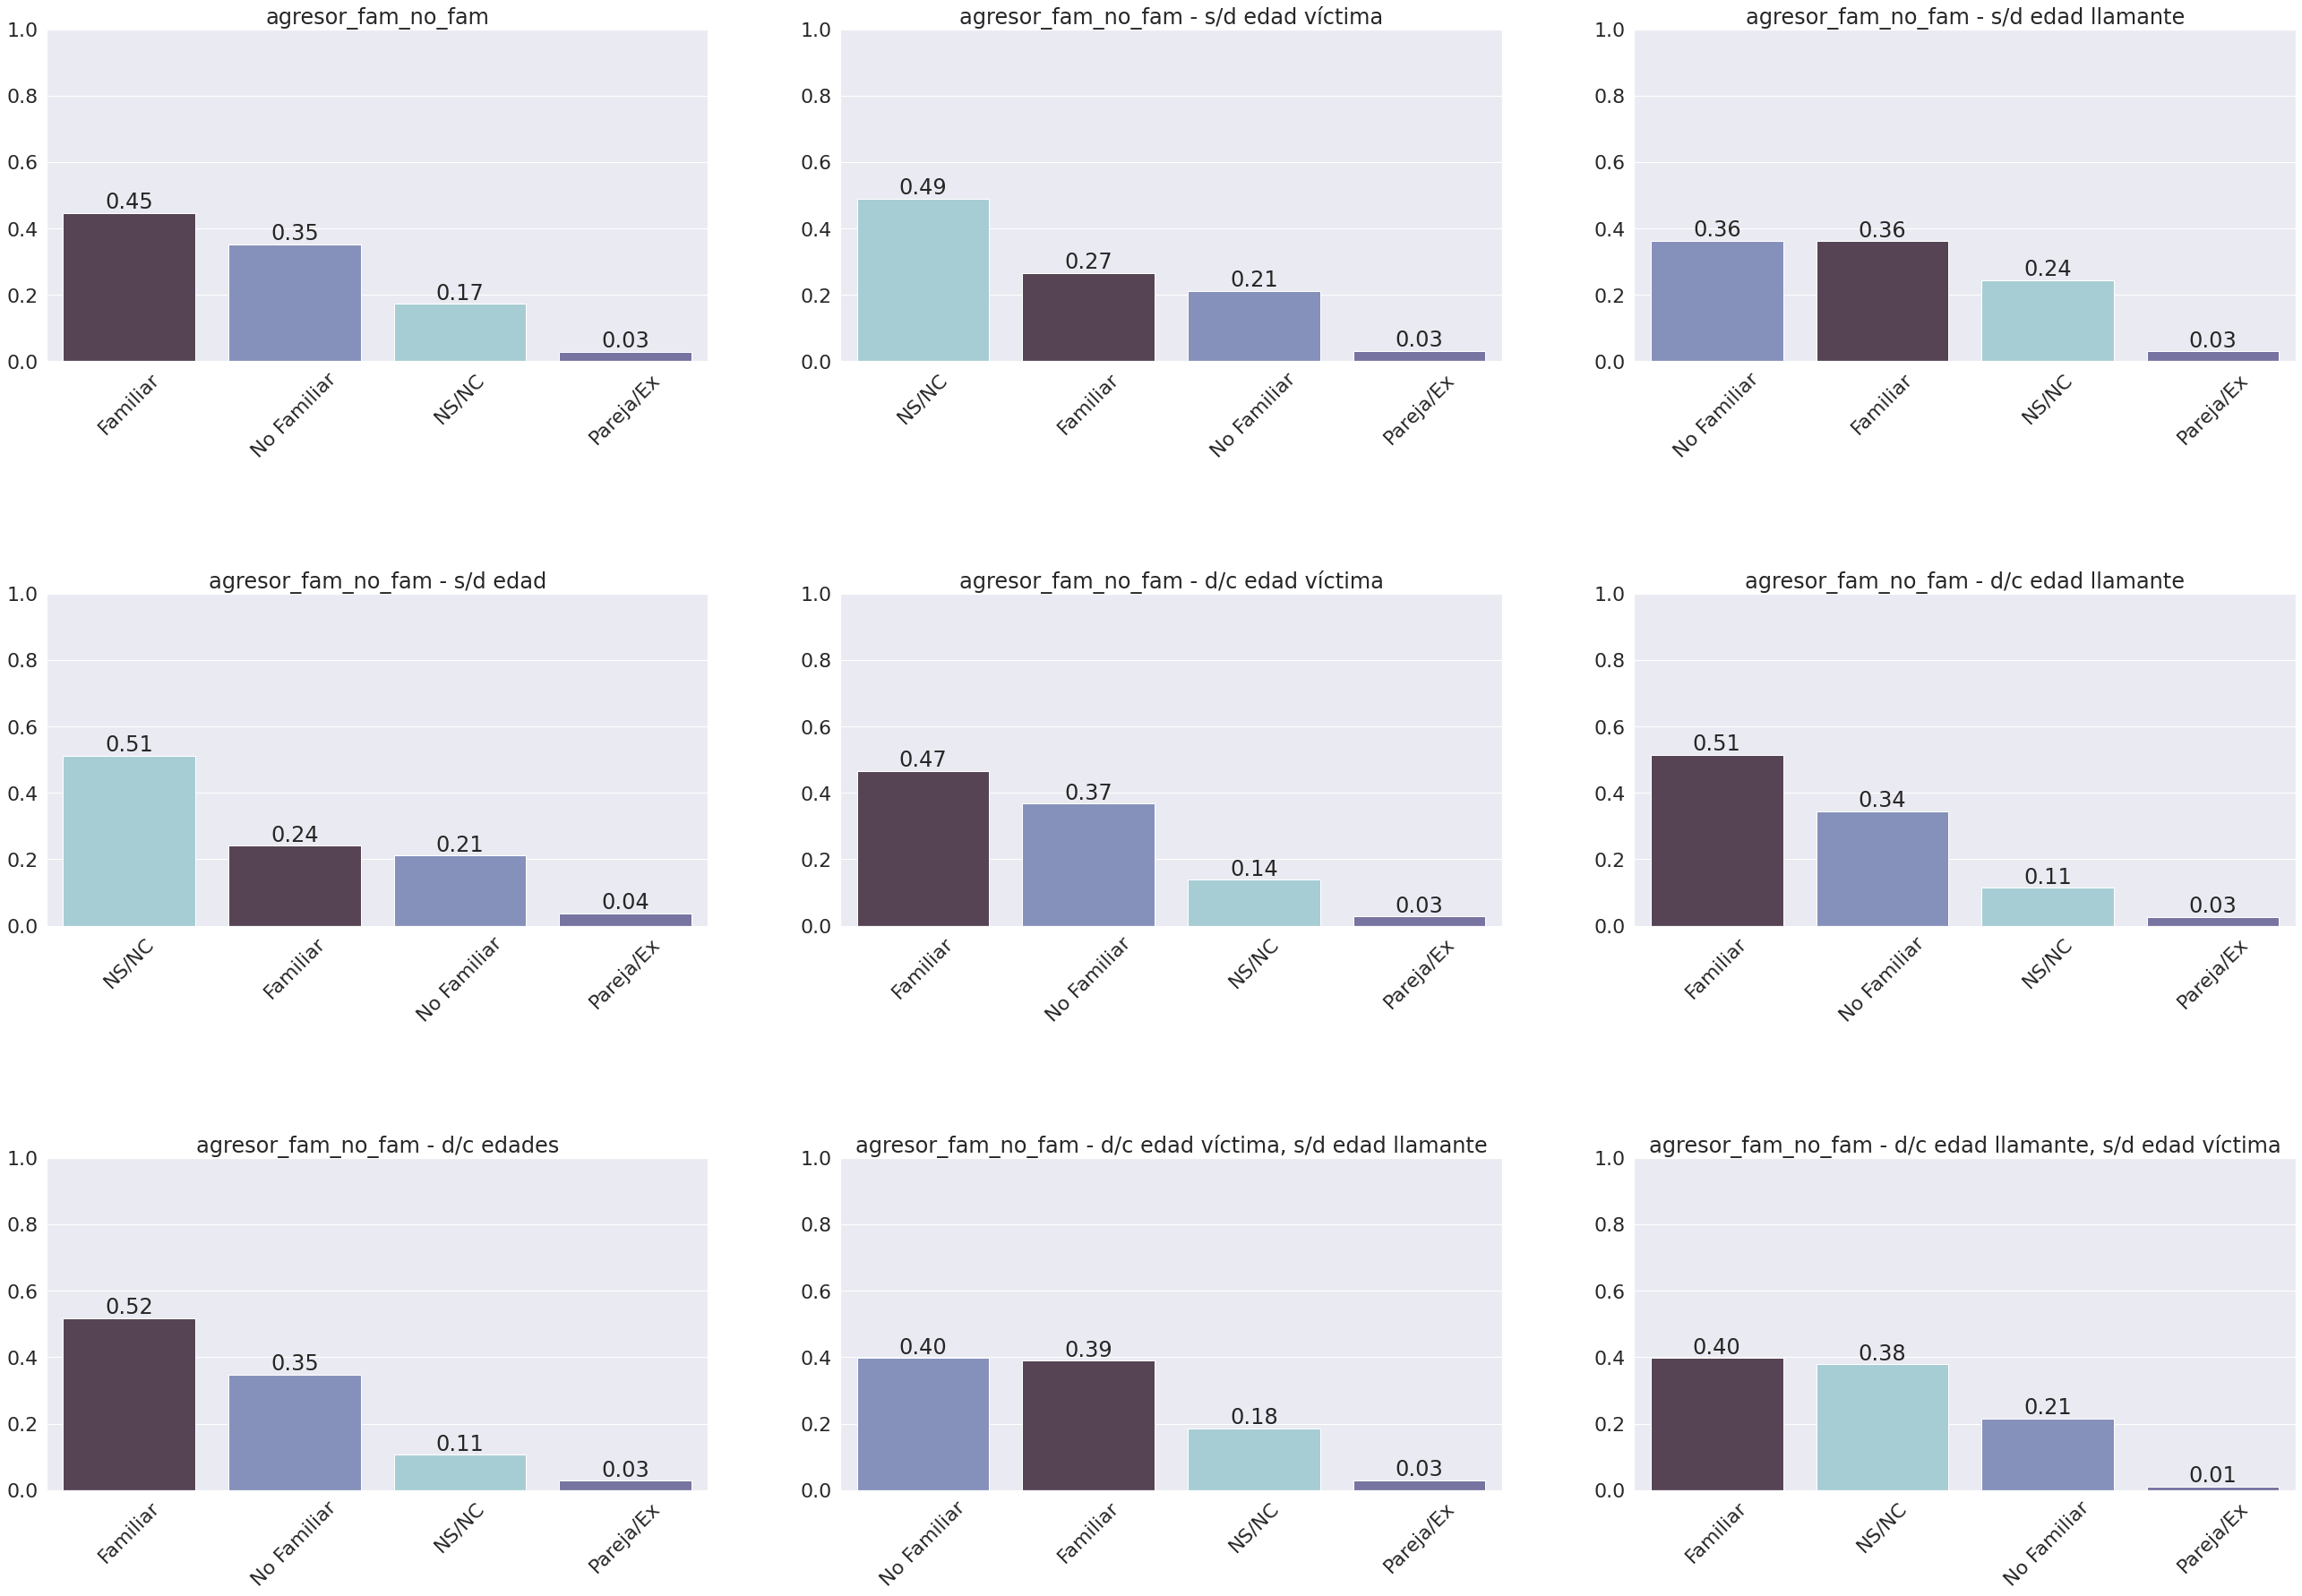

In [15]:
# graficar las diferencias de las variables en cada filtro 

# agresor_fam_no_fam

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))
fig.subplots_adjust(hspace=0.7)

# Plot the countplots with normalized values
sns.barplot(x=agresor_llamados_counts.index, y=agresor_llamados_counts.values, ax=ax[0, 0], palette=palette_agr_fam_nofam)
ax[0, 0].set_title('agresor_fam_no_fam')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{agresor_llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

###############################################################

sns.barplot(x=agresor_null_victima_edad_counts.index, y=agresor_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_agr_fam_nofam)
ax[0, 1].set_title('agresor_fam_no_fam - s/d edad víctima')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{agresor_null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


##############################################################    
    
sns.barplot(x=agresor_null_llamante_edad_counts.index, y=agresor_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_agr_fam_nofam)
ax[0, 2].set_title('agresor_fam_no_fam - s/d edad llamante')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=45)


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{agresor_null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
sns.barplot(x=agresor_null_edades_counts.index, y=agresor_null_edades_counts.values, ax=ax[1, 0], palette=palette_agr_fam_nofam)
ax[1, 0].set_title('agresor_fam_no_fam - s/d edad')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{agresor_null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
    
sns.barplot(x=agresor_completo_victima_edad_counts.index, y=agresor_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_agr_fam_nofam)
ax[1, 1].set_title('agresor_fam_no_fam - d/c edad víctima')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{agresor_completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################    

sns.barplot(x=agresor_completo_llamante_edad_counts.index, y=agresor_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_agr_fam_nofam)
ax[1, 2].set_title('agresor_fam_no_fam - d/c edad llamante')
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{agresor_completo_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################

    
sns.barplot(x=agresor_completo_edades_counts.index, y=agresor_completo_edades_counts.values, ax=ax[2, 0], palette=palette_agr_fam_nofam)
ax[2, 0].set_title('agresor_fam_no_fam - d/c edades')
ax[2, 0].set_xticklabels(ax[2, 0].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{agresor_completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################


sns.barplot(x=agresor_v_lleno_ll_vacio_edades_counts.index, y=agresor_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_agr_fam_nofam)
ax[2, 1].set_title('agresor_fam_no_fam - d/c edad víctima, s/d edad llamante')
ax[2, 1].set_xticklabels(ax[2, 1].get_xticklabels(), rotation=45)


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{agresor_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################
    
    
    
sns.barplot(x=agresor_v_vacio_ll_lleno_edades_counts.index, y=agresor_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_agr_fam_nofam)
ax[2, 2].set_title('agresor_fam_no_fam - d/c edad llamante, s/d edad víctima')
ax[2, 2].set_xticklabels(ax[2, 2].get_xticklabels(), rotation=45)


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{agresor_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


/var/folders/gm/4r6lhs5j5p12g3_ml4zjfy500000gq/T/ipykernel_15494/143371645.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agr_con_nc_llamados_counts.index, y=agr_con_nc_llamados_counts.values, ax=ax[0, 0], palette=palette_agr_con_nc)
/var/folders/gm/4r6lhs5j5p12g3_ml4zjfy500000gq/T/ipykernel_15494/143371645.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=45)
/var/folders/gm/4r6lhs5j5p12g3_ml4zjfy500000gq/T/ipykernel_15494/143371645.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agr_con_nc_null_victima_edad_counts.index, y=agr

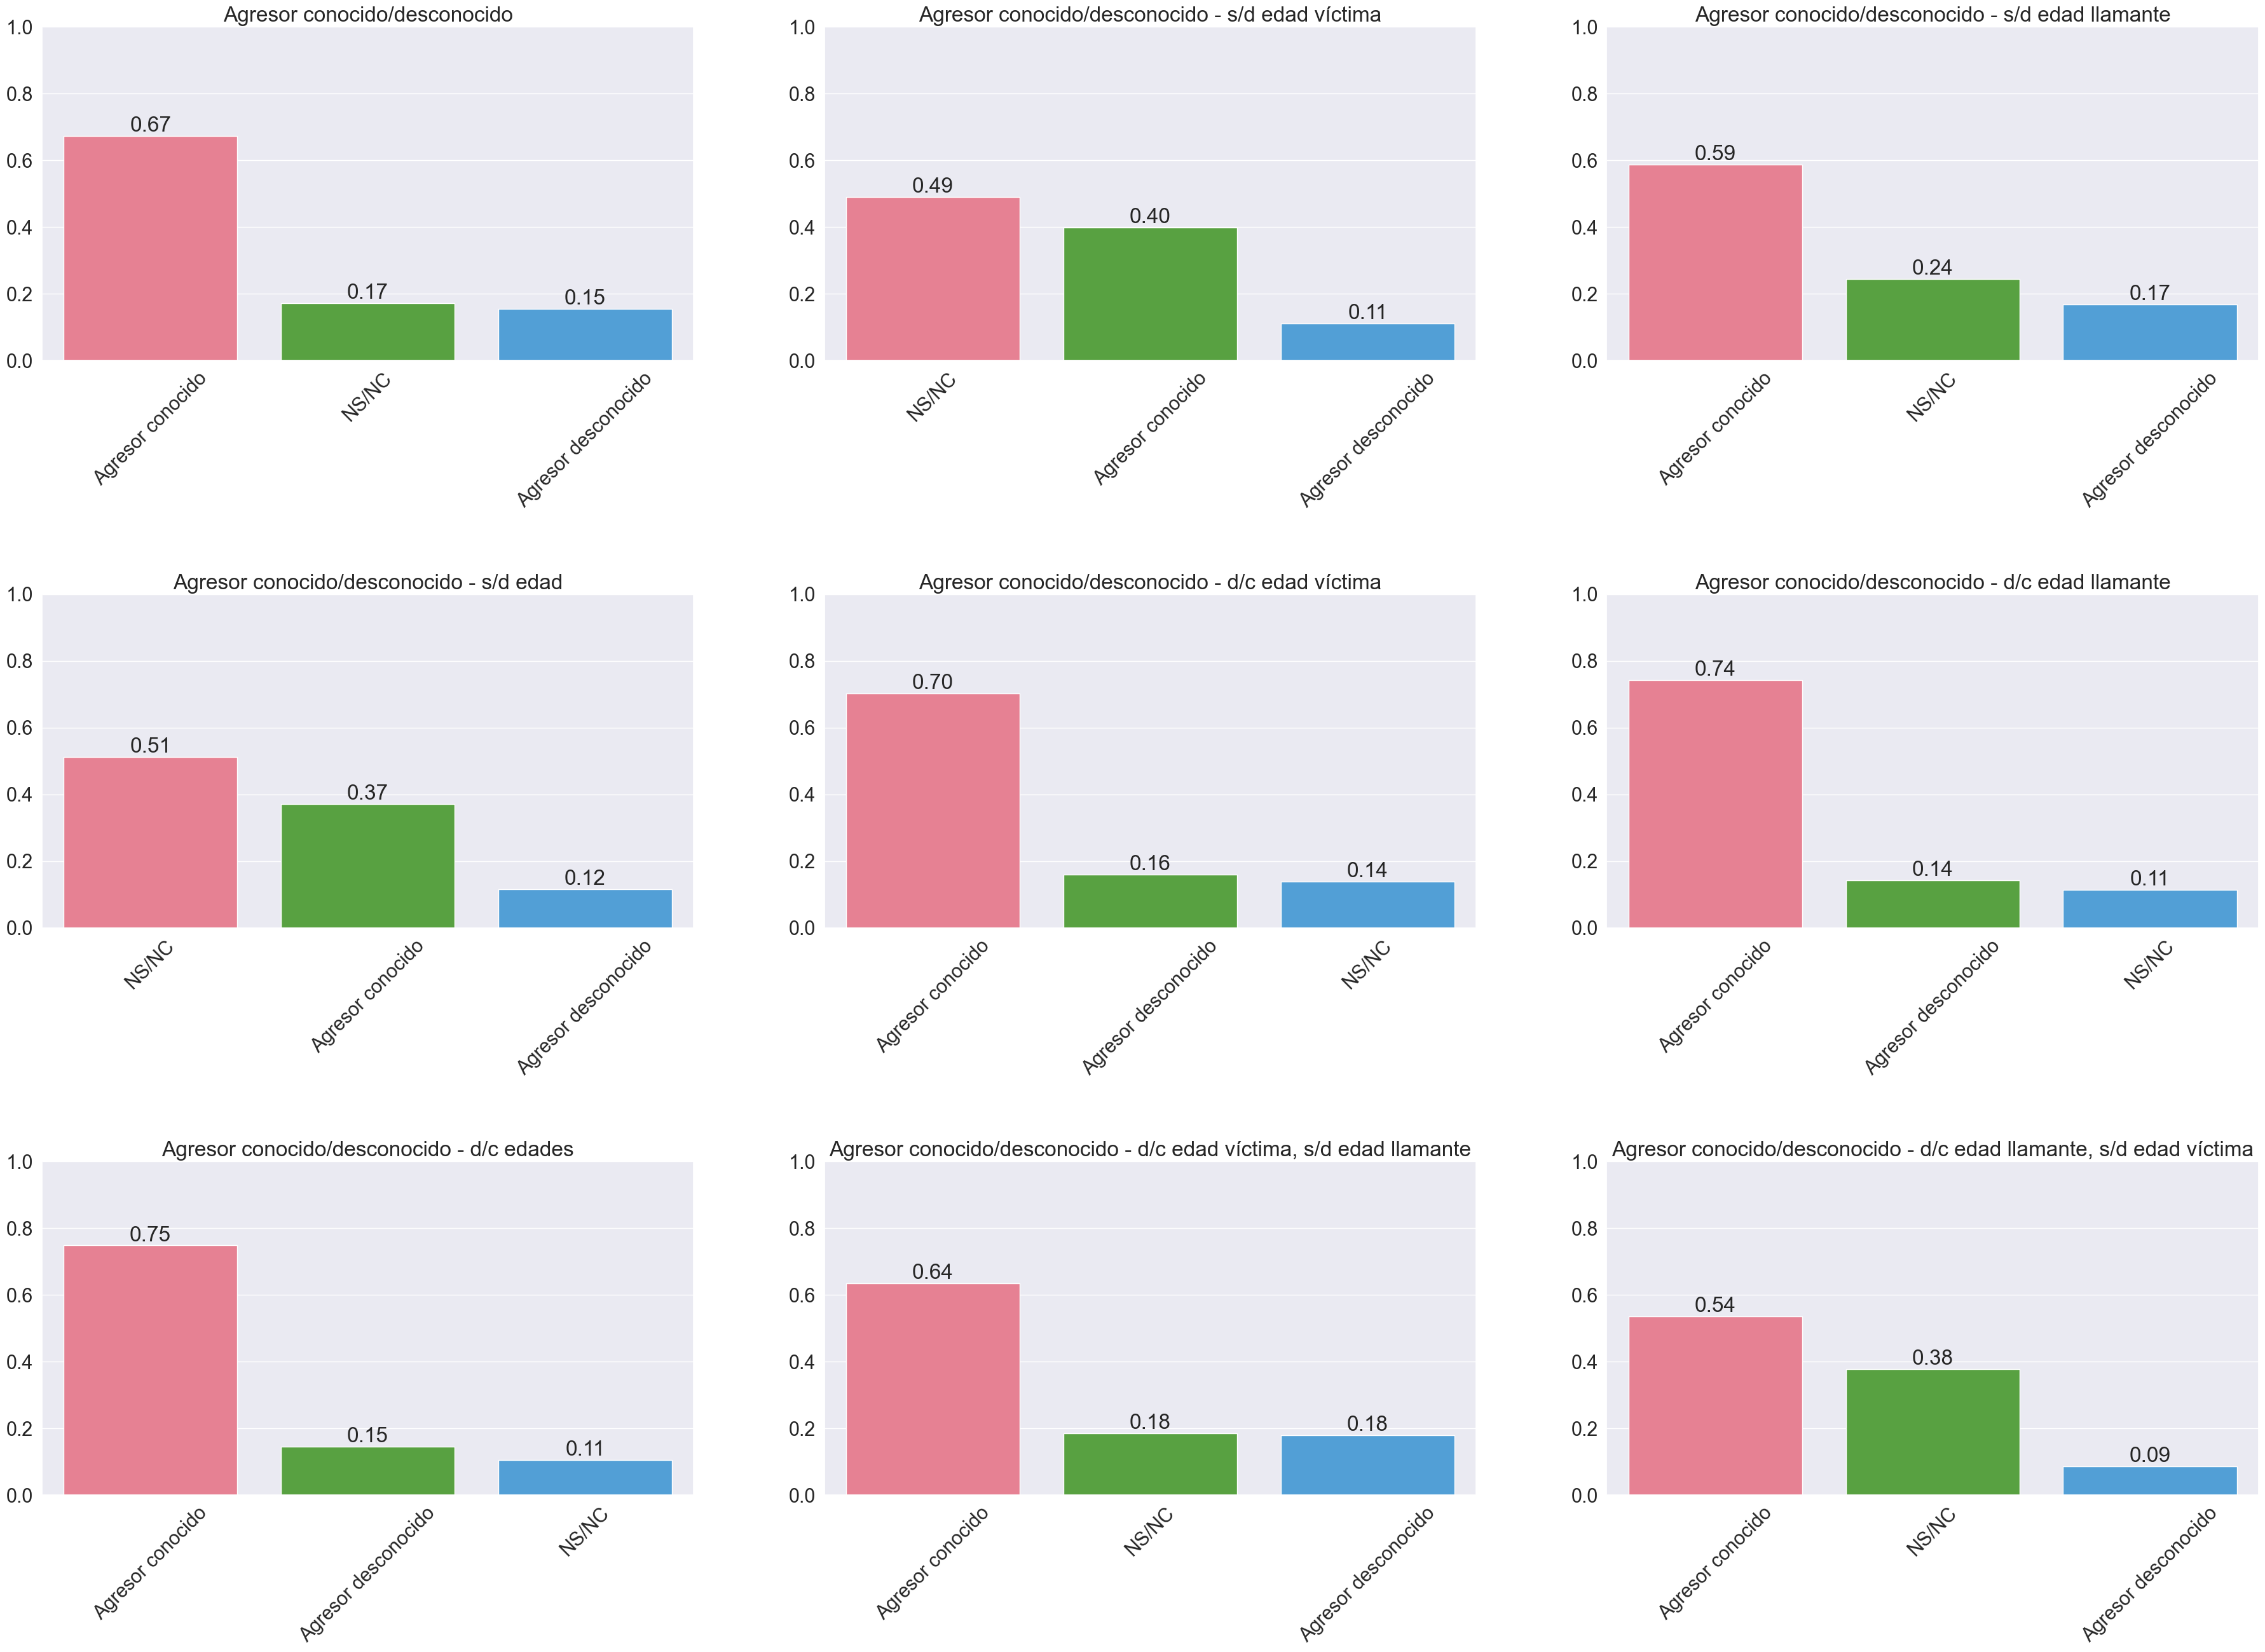

In [26]:
# graficar las diferencias de las variables en cada filtro 

# agresor_conocido_desconocido

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))
fig.subplots_adjust(hspace=0.7)

# Plot the countplots with normalized values
sns.barplot(x=agr_con_nc_llamados_counts.index, y=agr_con_nc_llamados_counts.values, ax=ax[0, 0], palette=palette_agr_con_nc)
ax[0, 0].set_title('Agresor conocido/desconocido')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=45)
ax[0, 0].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{agr_con_nc_llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

###############################################################

sns.barplot(x=agr_con_nc_null_victima_edad_counts.index, y=agr_con_nc_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_agr_con_nc)
ax[0, 1].set_title('Agresor conocido/desconocido - s/d edad víctima')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=45)
ax[0, 1].set_xlabel('') 
# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{agr_con_nc_null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


##############################################################    
    
sns.barplot(x=agr_con_nc_null_llamante_edad_counts.index, y=agr_con_nc_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_agr_con_nc)
ax[0, 2].set_title('Agresor conocido/desconocido - s/d edad llamante')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=45)
ax[0, 2].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{agr_con_nc_null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
sns.barplot(x=agr_con_nc_null_edades_counts.index, y=agr_con_nc_null_edades_counts.values, ax=ax[1, 0], palette=palette_agr_con_nc)
ax[1, 0].set_title('Agresor conocido/desconocido - s/d edad')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=45)
ax[1, 0].set_xlabel('') 
# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{agr_con_nc_null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
    
sns.barplot(x=agr_con_nc_completo_victima_edad_counts.index, y=agr_con_nc_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_agr_con_nc)
ax[1, 1].set_title('Agresor conocido/desconocido - d/c edad víctima')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45)
ax[1, 1].set_xlabel('') 
# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{agr_con_nc_completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################    

sns.barplot(x=agr_con_nc_completo_llamante_edad_counts.index, y=agr_con_nc_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_agr_con_nc)
ax[1, 2].set_title('Agresor conocido/desconocido - d/c edad llamante')
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45)
ax[1, 2].set_xlabel('') 
# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{agr_con_nc_completo_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################

    
sns.barplot(x=agr_con_nc_completo_edades_counts.index, y=agr_con_nc_completo_edades_counts.values, ax=ax[2, 0], palette=palette_agr_con_nc)
ax[2, 0].set_title('Agresor conocido/desconocido - d/c edades')
ax[2, 0].set_xticklabels(ax[2, 0].get_xticklabels(), rotation=45)
ax[2, 0].set_xlabel('') 
# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{agr_con_nc_completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################


sns.barplot(x=agr_con_nc_v_lleno_ll_vacio_edades_counts.index, y=agr_con_nc_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_agr_con_nc)
ax[2, 1].set_title('Agresor conocido/desconocido - d/c edad víctima, s/d edad llamante')
ax[2, 1].set_xticklabels(ax[2, 1].get_xticklabels(), rotation=45)
ax[2, 1].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{agr_con_nc_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################
    
    
    
sns.barplot(x=agr_con_nc_v_vacio_ll_lleno_edades_counts.index, y=agr_con_nc_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_agr_con_nc)
ax[2, 2].set_title('Agresor conocido/desconocido - d/c edad llamante, s/d edad víctima')
ax[2, 2].set_xticklabels(ax[2, 2].get_xticklabels(), rotation=45)
ax[2, 2].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{agr_con_nc_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


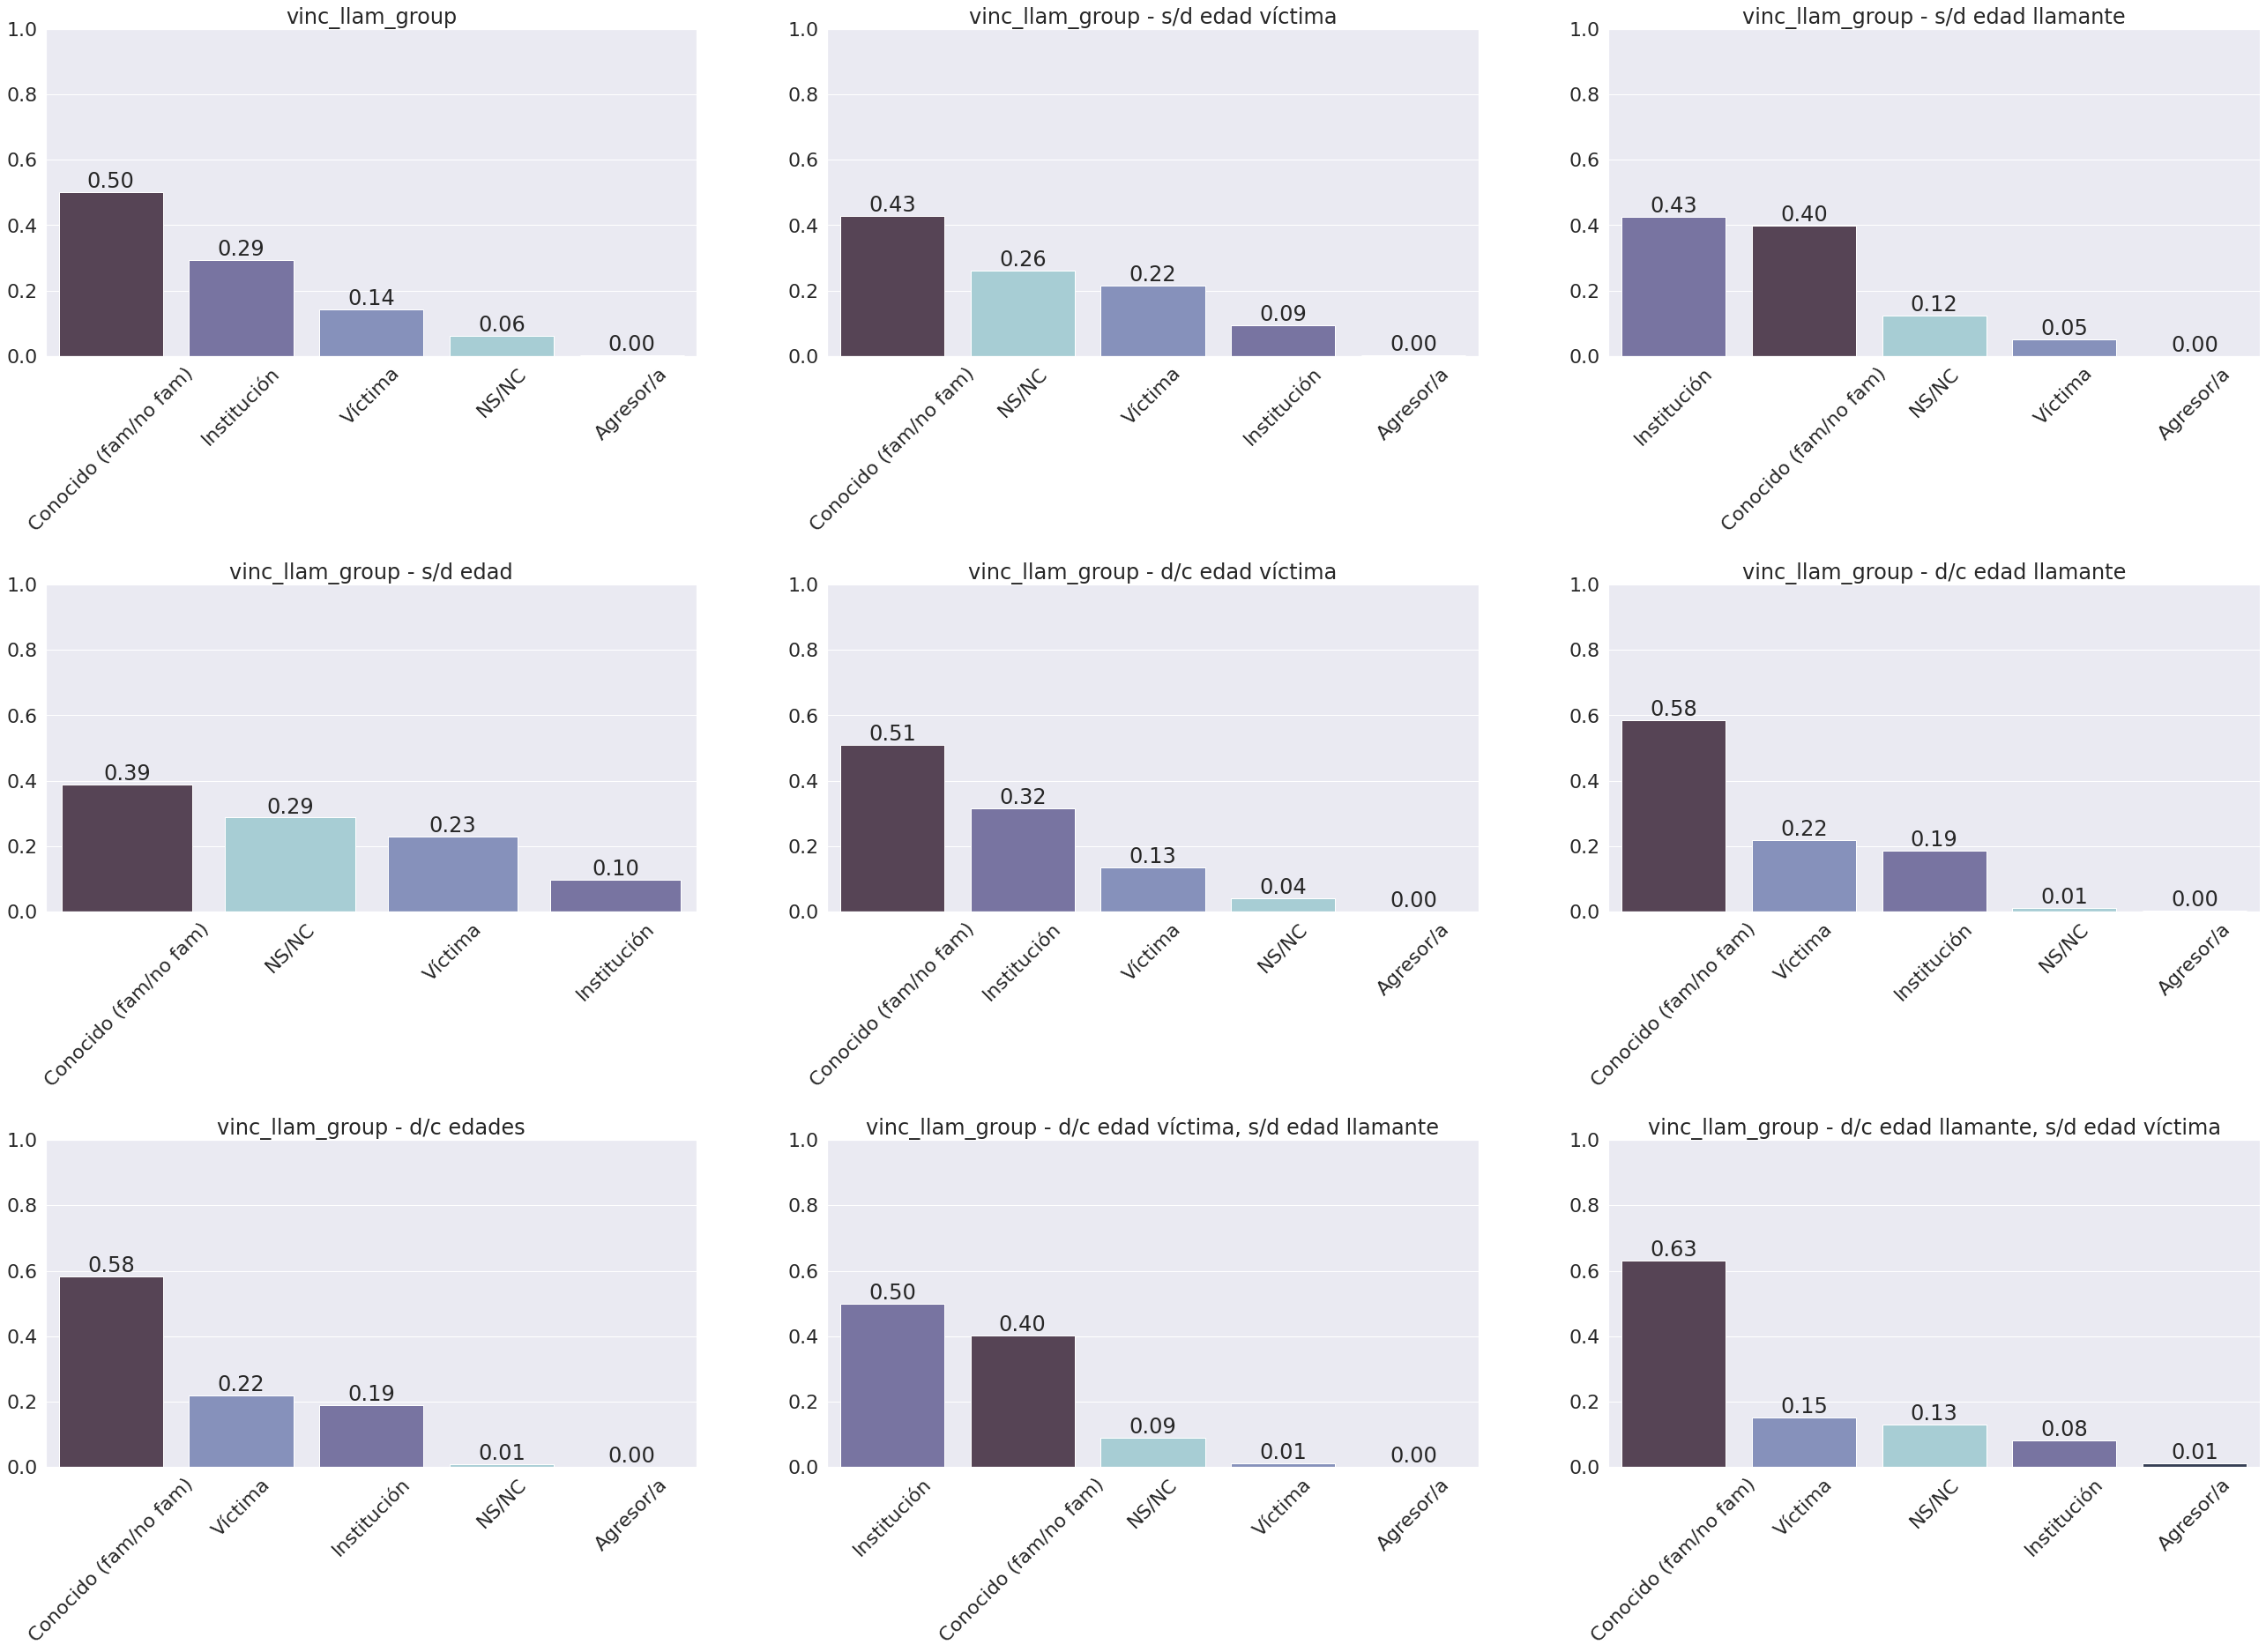

In [17]:
# graficar las diferencias de las variables en cada filtro 

# vinc_llam_group

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))
fig.subplots_adjust(hspace=0.7)

# Plot the countplots with normalized values
sns.barplot(x=vinc_llam_gr_llamados_counts.index, y=vinc_llam_gr_llamados_counts.values, ax=ax[0, 0], palette=palette_vinc_llam_gr)
ax[0, 0].set_title('vinc_llam_group')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{vinc_llam_gr_llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

###############################################################

sns.barplot(x=vinc_llam_gr_null_victima_edad_counts.index, y=vinc_llam_gr_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_vinc_llam_gr)
ax[0, 1].set_title('vinc_llam_group - s/d edad víctima')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{vinc_llam_gr_null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


##############################################################    
    
sns.barplot(x=vinc_llam_gr_null_llamante_edad_counts.index, y=vinc_llam_gr_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_vinc_llam_gr)
ax[0, 2].set_title('vinc_llam_group - s/d edad llamante')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=45)


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{vinc_llam_gr_null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
sns.barplot(x=vinc_llam_gr_null_edades_counts.index, y=vinc_llam_gr_null_edades_counts.values, ax=ax[1, 0], palette=palette_vinc_llam_gr)
ax[1, 0].set_title('vinc_llam_group - s/d edad')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{vinc_llam_gr_null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
    
sns.barplot(x=vinc_llam_gr_completo_victima_edad_counts.index, y=vinc_llam_gr_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_vinc_llam_gr)
ax[1, 1].set_title('vinc_llam_group - d/c edad víctima')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{vinc_llam_gr_completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################    

sns.barplot(x=vinc_llam_gr_completo_llamante_edad_counts.index, y=vinc_llam_gr_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_vinc_llam_gr)
ax[1, 2].set_title('vinc_llam_group - d/c edad llamante')
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{vinc_llam_gr_completo_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################

    
sns.barplot(x=vinc_llam_gr_completo_edades_counts.index, y=vinc_llam_gr_completo_edades_counts.values, ax=ax[2, 0], palette=palette_vinc_llam_gr)
ax[2, 0].set_title('vinc_llam_group - d/c edades')
ax[2, 0].set_xticklabels(ax[2, 0].get_xticklabels(), rotation=45)

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{vinc_llam_gr_completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################


sns.barplot(x=vinc_llam_gr_v_lleno_ll_vacio_edades_counts.index, y=vinc_llam_gr_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_vinc_llam_gr)
ax[2, 1].set_title('vinc_llam_group - d/c edad víctima, s/d edad llamante')
ax[2, 1].set_xticklabels(ax[2, 1].get_xticklabels(), rotation=45)


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{vinc_llam_gr_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################
    
    
    
sns.barplot(x=vinc_llam_gr_v_vacio_ll_lleno_edades_counts.index, y=vinc_llam_gr_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_vinc_llam_gr)
ax[2, 2].set_title('vinc_llam_group - d/c edad llamante, s/d edad víctima')
ax[2, 2].set_xticklabels(ax[2, 2].get_xticklabels(), rotation=45)


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{vinc_llam_gr_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


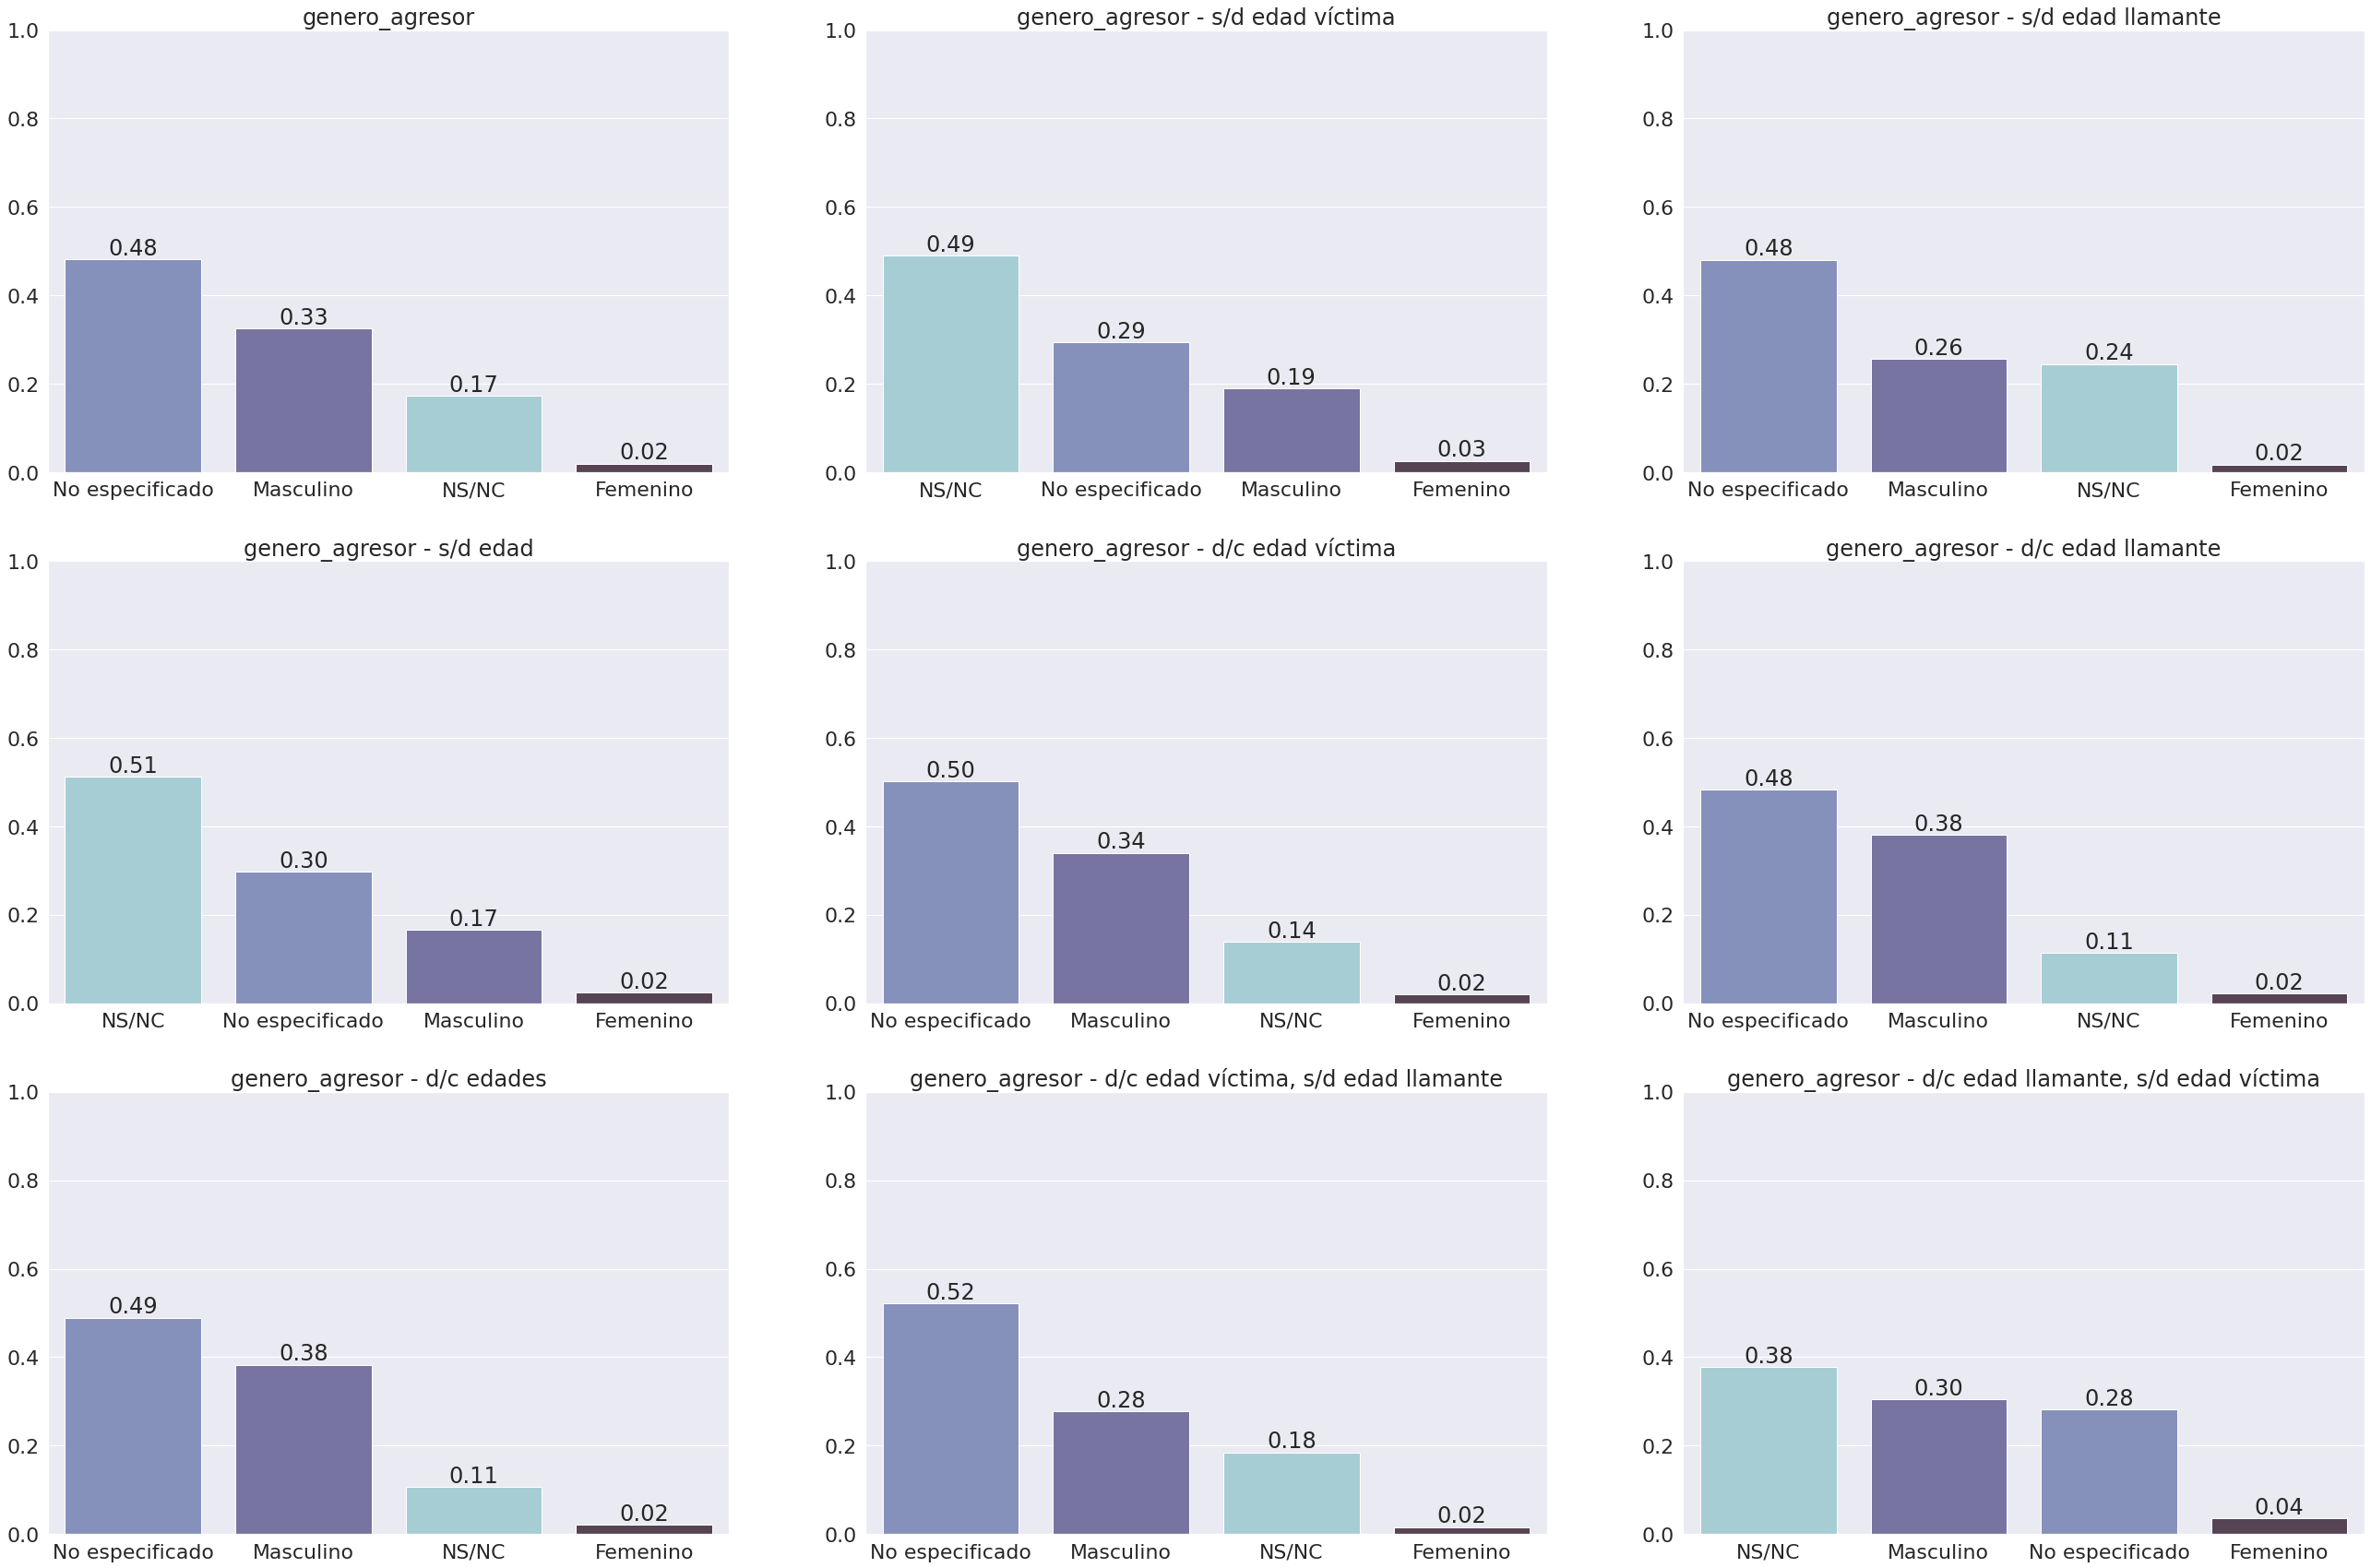

In [16]:
# graficar las diferencias de las variables en cada filtro 

# genero_agresor

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))

# Plot the countplots with normalized values
sns.barplot(x=genagr_llamados_counts.index, y=genagr_llamados_counts.values, ax=ax[0, 0], palette=palette_gen_agr)
ax[0, 0].set_title('genero_agresor')

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{genagr_llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

###############################################################

sns.barplot(x=genagr_null_victima_edad_counts.index, y=genagr_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_gen_agr)
ax[0, 1].set_title('genero_agresor - s/d edad víctima')

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{genagr_null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


##############################################################    
    
sns.barplot(x=genagr_null_llamante_edad_counts.index, y=genagr_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_gen_agr)
ax[0, 2].set_title('genero_agresor - s/d edad llamante')

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{genagr_null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
sns.barplot(x=genagr_null_edades_counts.index, y=genagr_null_edades_counts.values, ax=ax[1, 0], palette=palette_gen_agr)
ax[1, 0].set_title('genero_agresor - s/d edad')

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{genagr_null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
    
sns.barplot(x=genagr_completo_victima_edad_counts.index, y=genagr_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_gen_agr)
ax[1, 1].set_title('genero_agresor - d/c edad víctima')

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{genagr_completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################    

sns.barplot(x=genagr_completo_llamante_edad_counts.index, y=genagr_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_gen_agr)
ax[1, 2].set_title('genero_agresor - d/c edad llamante')

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{genagr_completo_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################

    
sns.barplot(x=genagr_completo_edades_counts.index, y=genagr_completo_edades_counts.values, ax=ax[2, 0], palette=palette_gen_agr)
ax[2, 0].set_title('genero_agresor - d/c edades')

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{genagr_completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################


sns.barplot(x=genagr_v_lleno_ll_vacio_edades_counts.index, y=genagr_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_gen_agr)
ax[2, 1].set_title('genero_agresor - d/c edad víctima, s/d edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{genagr_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################
    
    
    
sns.barplot(x=genagr_v_vacio_ll_lleno_edades_counts.index, y=genagr_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_gen_agr)
ax[2, 2].set_title('genero_agresor - d/c edad llamante, s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{genagr_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


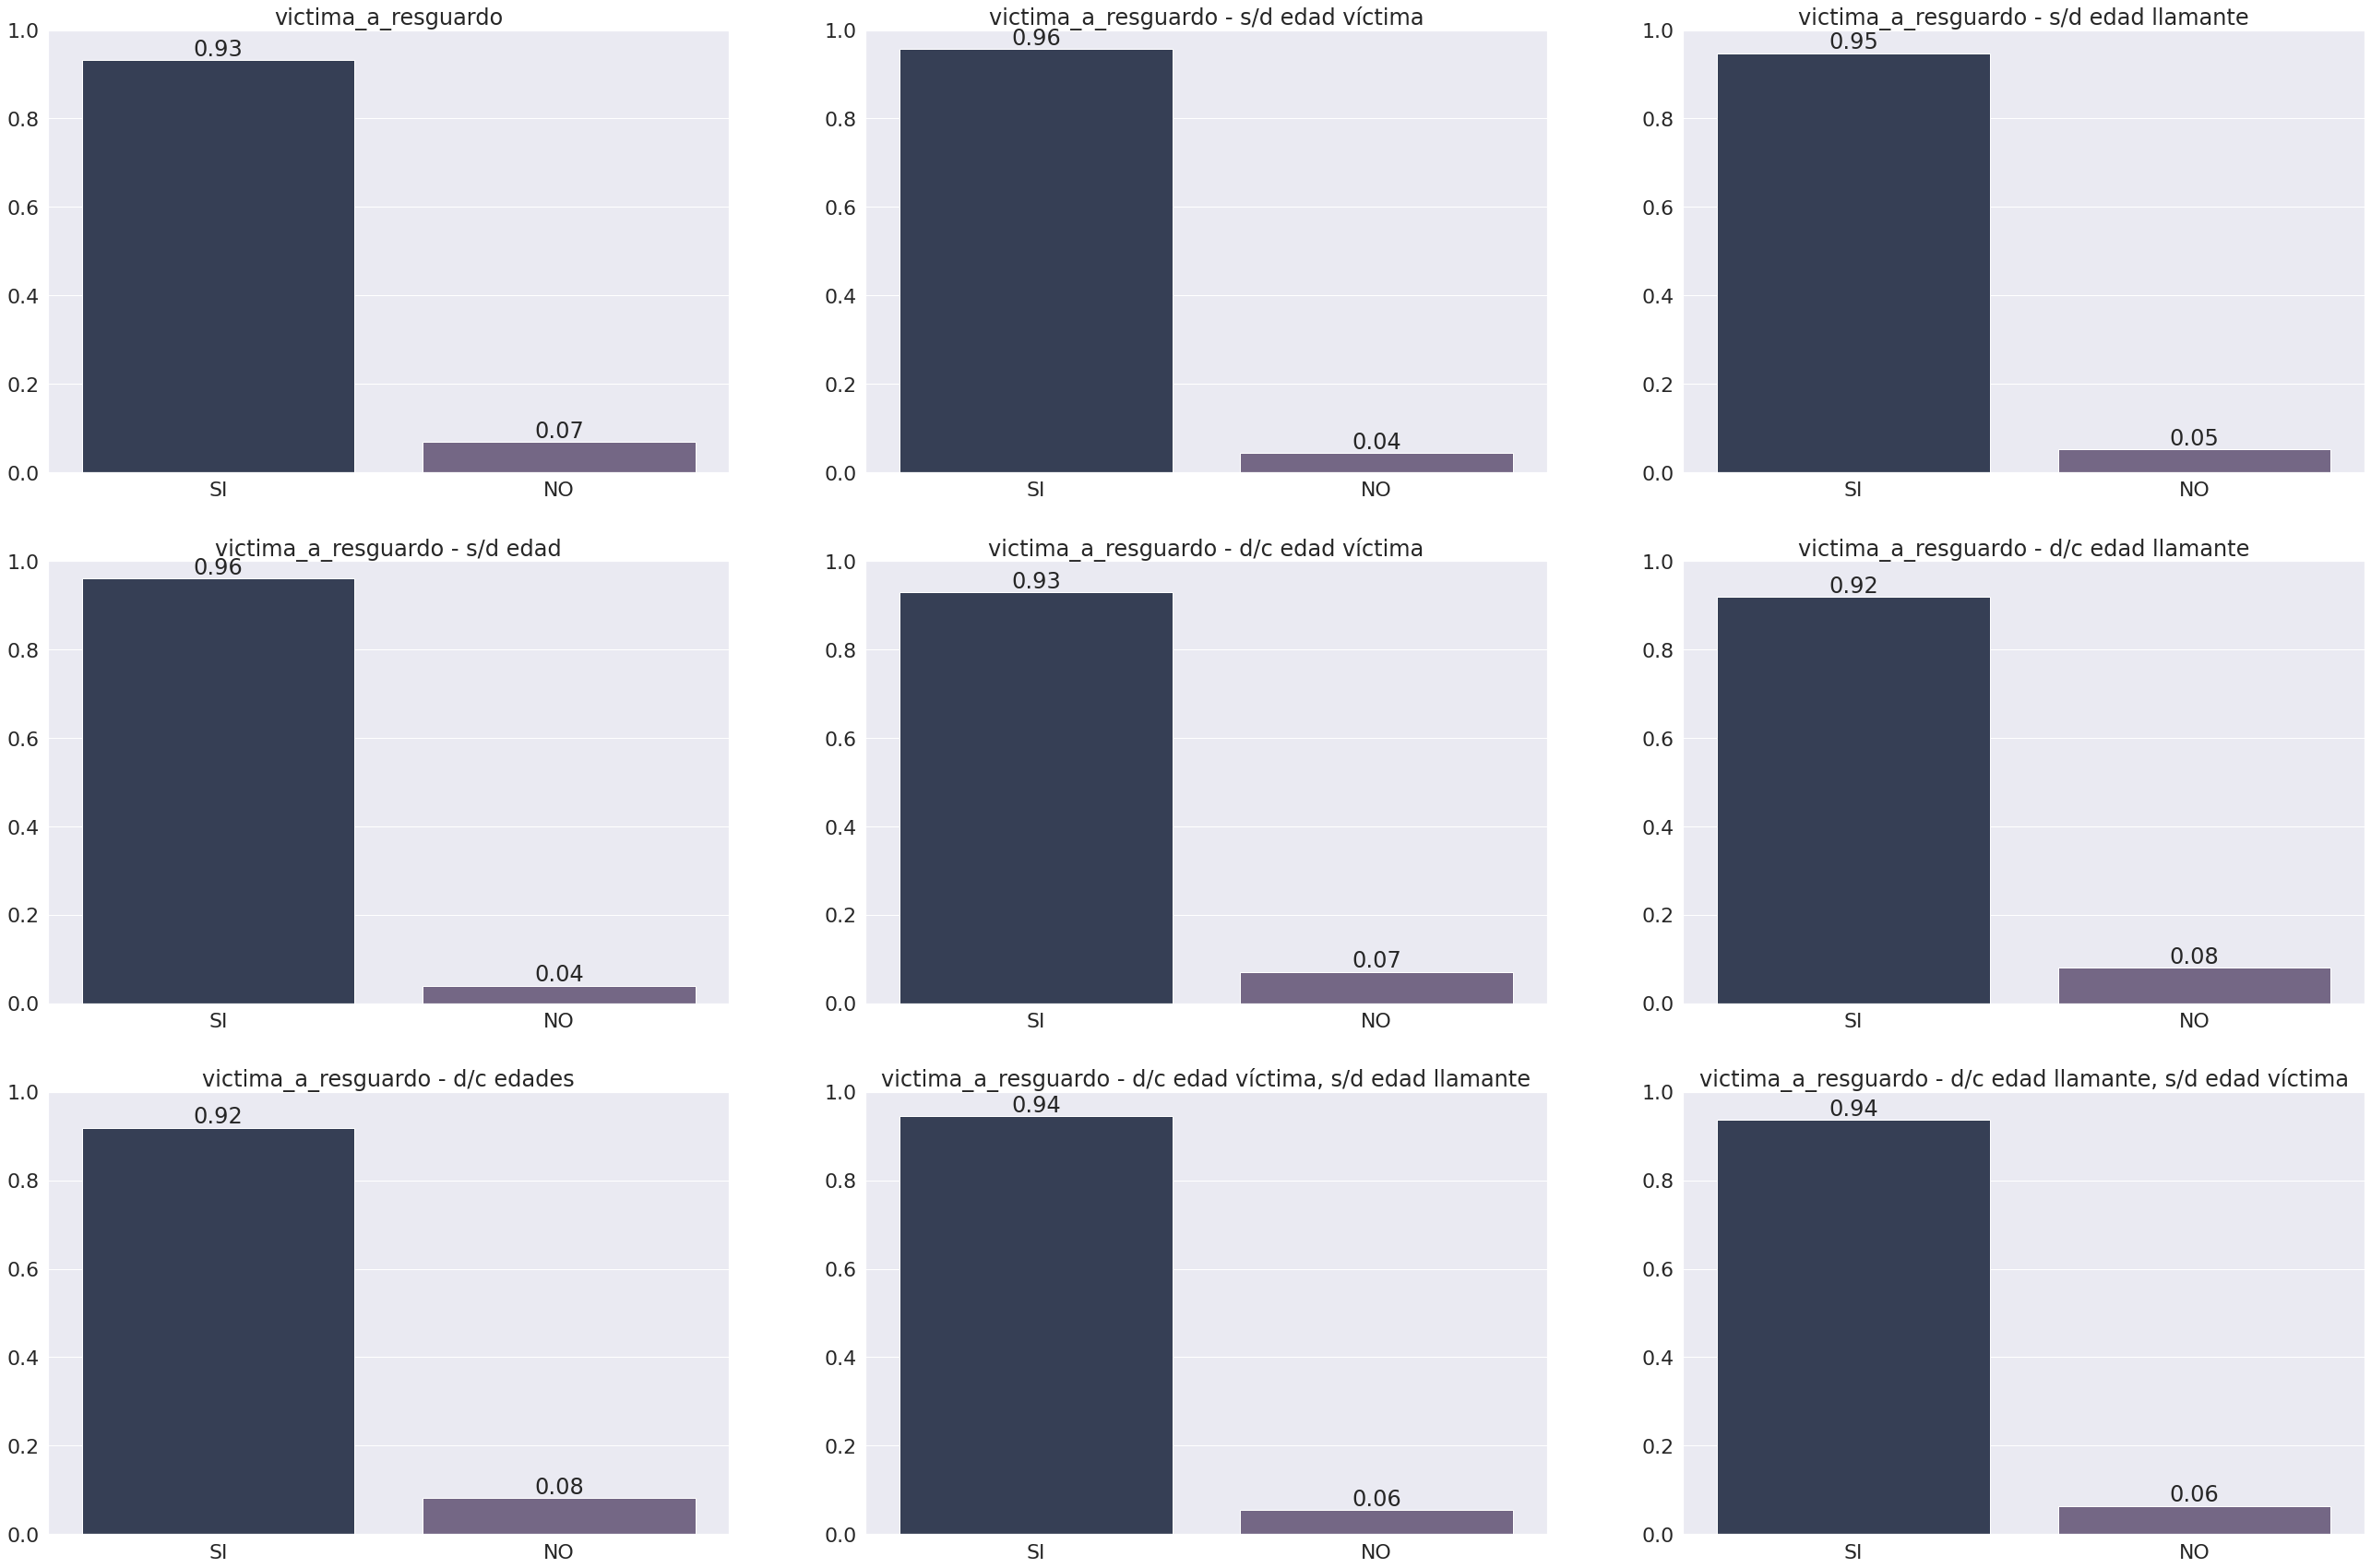

In [17]:
# graficar las diferencias de las variables en cada filtro 

# victima a resguardo

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))

# Plot the countplots with normalized values
sns.barplot(x=resguardo_llamados_counts.index, y=resguardo_llamados_counts.values, ax=ax[0, 0], palette=palette_sino)
ax[0, 0].set_title('victima_a_resguardo')

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{resguardo_llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

###############################################################

sns.barplot(x=resguardo_null_victima_edad_counts.index, y=resguardo_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_sino)
ax[0, 1].set_title('victima_a_resguardo - s/d edad víctima')

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{resguardo_null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


##############################################################    
    
sns.barplot(x=resguardo_null_llamante_edad_counts.index, y=resguardo_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_sino)
ax[0, 2].set_title('victima_a_resguardo - s/d edad llamante')

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{resguardo_null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
sns.barplot(x=resguardo_null_edades_counts.index, y=resguardo_null_edades_counts.values, ax=ax[1, 0], palette=palette_sino)
ax[1, 0].set_title('victima_a_resguardo - s/d edad')

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{resguardo_null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    
    
    
sns.barplot(x=resguardo_completo_victima_edad_counts.index, y=resguardo_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_sino)
ax[1, 1].set_title('victima_a_resguardo - d/c edad víctima')

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{resguardo_completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################    

sns.barplot(x=resguardo_completo_llamante_edad_counts.index, y=resguardo_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_sino)
ax[1, 2].set_title('victima_a_resguardo - d/c edad llamante')

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{resguardo_completo_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################

    
sns.barplot(x=resguardo_completo_edades_counts.index, y=resguardo_completo_edades_counts.values, ax=ax[2, 0], palette=palette_sino)
ax[2, 0].set_title('victima_a_resguardo - d/c edades')

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{resguardo_completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


    
#############################################################


sns.barplot(x=resguardo_v_lleno_ll_vacio_edades_counts.index, y=resguardo_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_sino)
ax[2, 1].set_title('victima_a_resguardo - d/c edad víctima, s/d edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{resguardo_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################
    
    
    
sns.barplot(x=resguardo_v_vacio_ll_lleno_edades_counts.index, y=resguardo_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_sino)
ax[2, 2].set_title('victima_a_resguardo - d/c edad llamante, s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{resguardo_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


#############################################################    

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


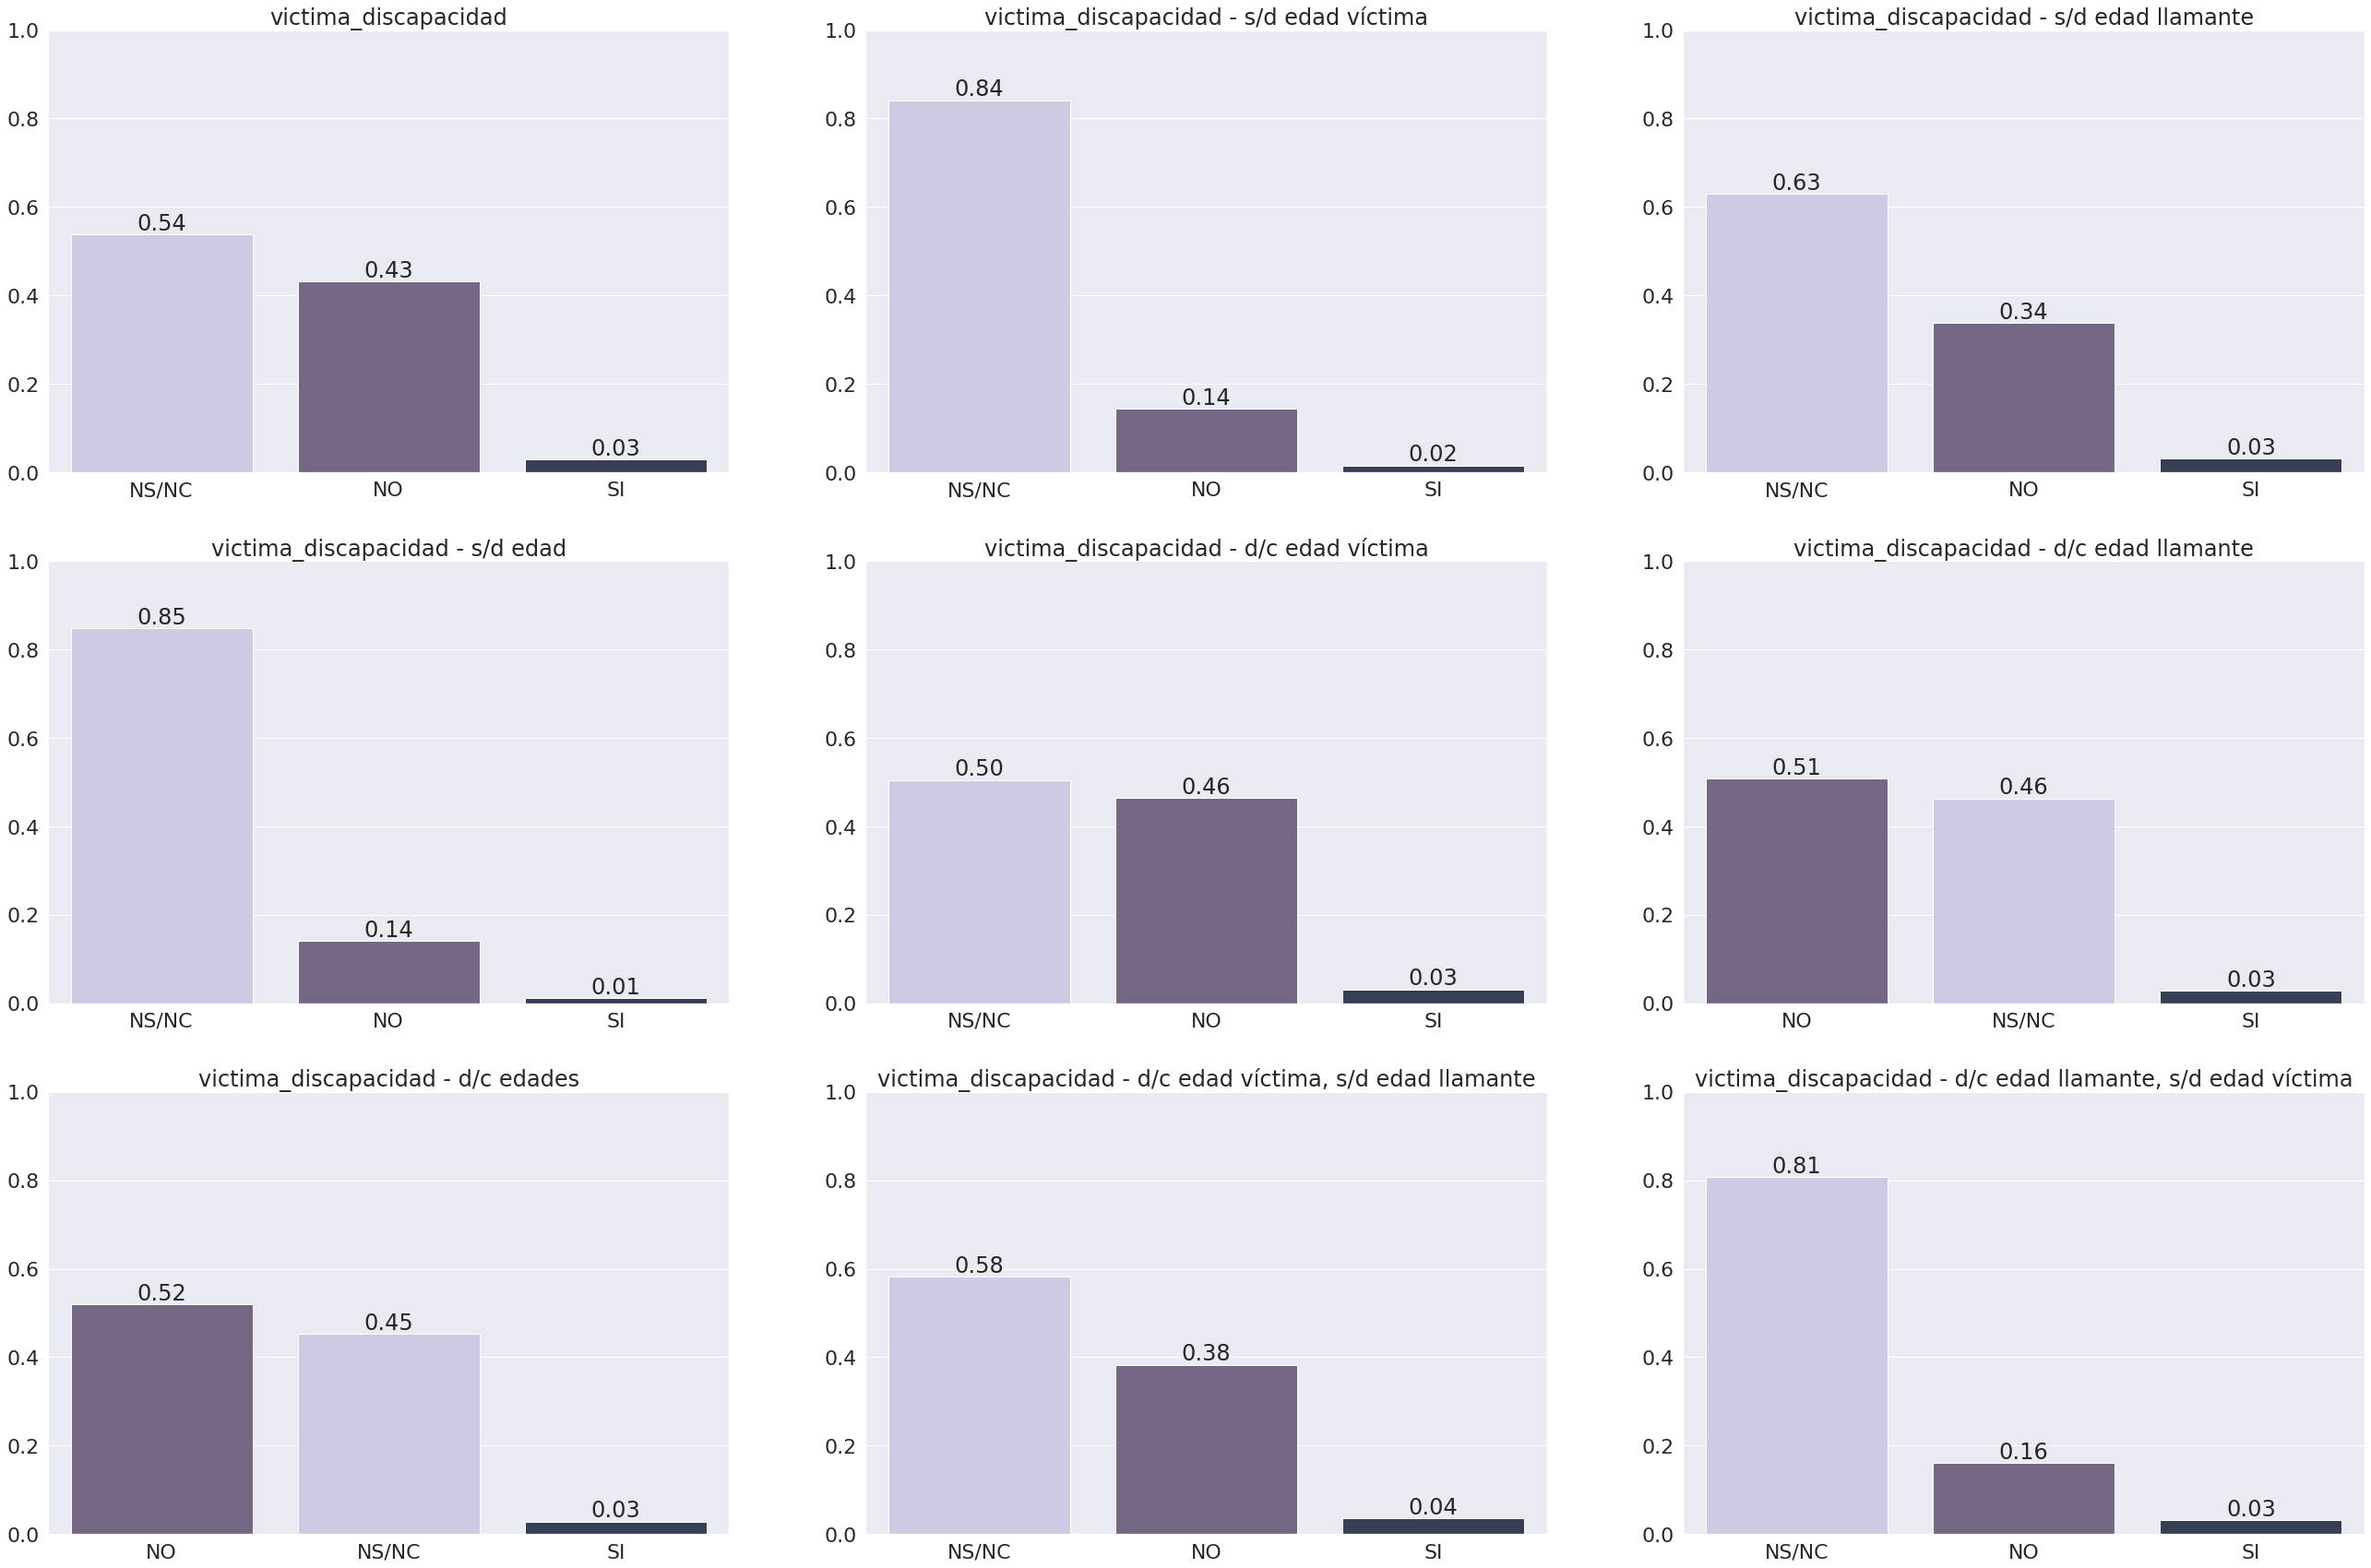

In [18]:
# graficar las diferencias de las variables en cada filtro 

# victima discapacidad

# Set up the figure and axes



sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))

# Plot the countplots with normalized values
sns.barplot(x=llamados_counts.index, y=llamados_counts.values, ax=ax[0, 0], palette=palette_sino)
ax[0, 0].set_title('victima_discapacidad')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



#############################################################    
    

sns.barplot(x=null_victima_edad_counts.index, y=null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_sino)
ax[0, 1].set_title('victima_discapacidad - s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=null_llamante_edad_counts.index, y=null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_sino)
ax[0, 2].set_title('victima_discapacidad - s/d edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=null_edades_counts.index, y=null_edades_counts.values, ax=ax[1, 0], palette=palette_sino)
ax[1, 0].set_title('victima_discapacidad - s/d edad')


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 

sns.barplot(x=completo_victima_edad_counts.index, y=completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_sino)
ax[1, 1].set_title('victima_discapacidad - d/c edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=completo_llamante_edad_counts.index, y=completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_sino)
ax[1, 2].set_title('victima_discapacidad - d/c edad llamante')



# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{completo_llamante_edad_counts.values[i]:.2f}',(p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 

sns.barplot(x=completo_edades_counts.index, y=completo_edades_counts.values, ax=ax[2, 0], palette=palette_sino)
ax[2, 0].set_title('victima_discapacidad - d/c edades')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=v_lleno_ll_vacio_edades_counts.index, y=v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_sino)
ax[2, 1].set_title('victima_discapacidad - d/c edad víctima, s/d edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 

sns.barplot(x=v_vacio_ll_lleno_edades_counts.index, y=v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_sino)
ax[2, 2].set_title('victima_discapacidad - d/c edad llamante, s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


/var/folders/gm/4r6lhs5j5p12g3_ml4zjfy500000gq/T/ipykernel_15494/3336496066.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=convive_llamados_counts.index, y=convive_llamados_counts.values, ax=ax[0, 0], palette=palette_sino)
/var/folders/gm/4r6lhs5j5p12g3_ml4zjfy500000gq/T/ipykernel_15494/3336496066.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=convive_null_victima_edad_counts.index, y=convive_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_sino)
/var/folders/gm/4r6lhs5j5p12g3_ml4zjfy500000gq/T/ipykernel_15494/3336496066.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hu

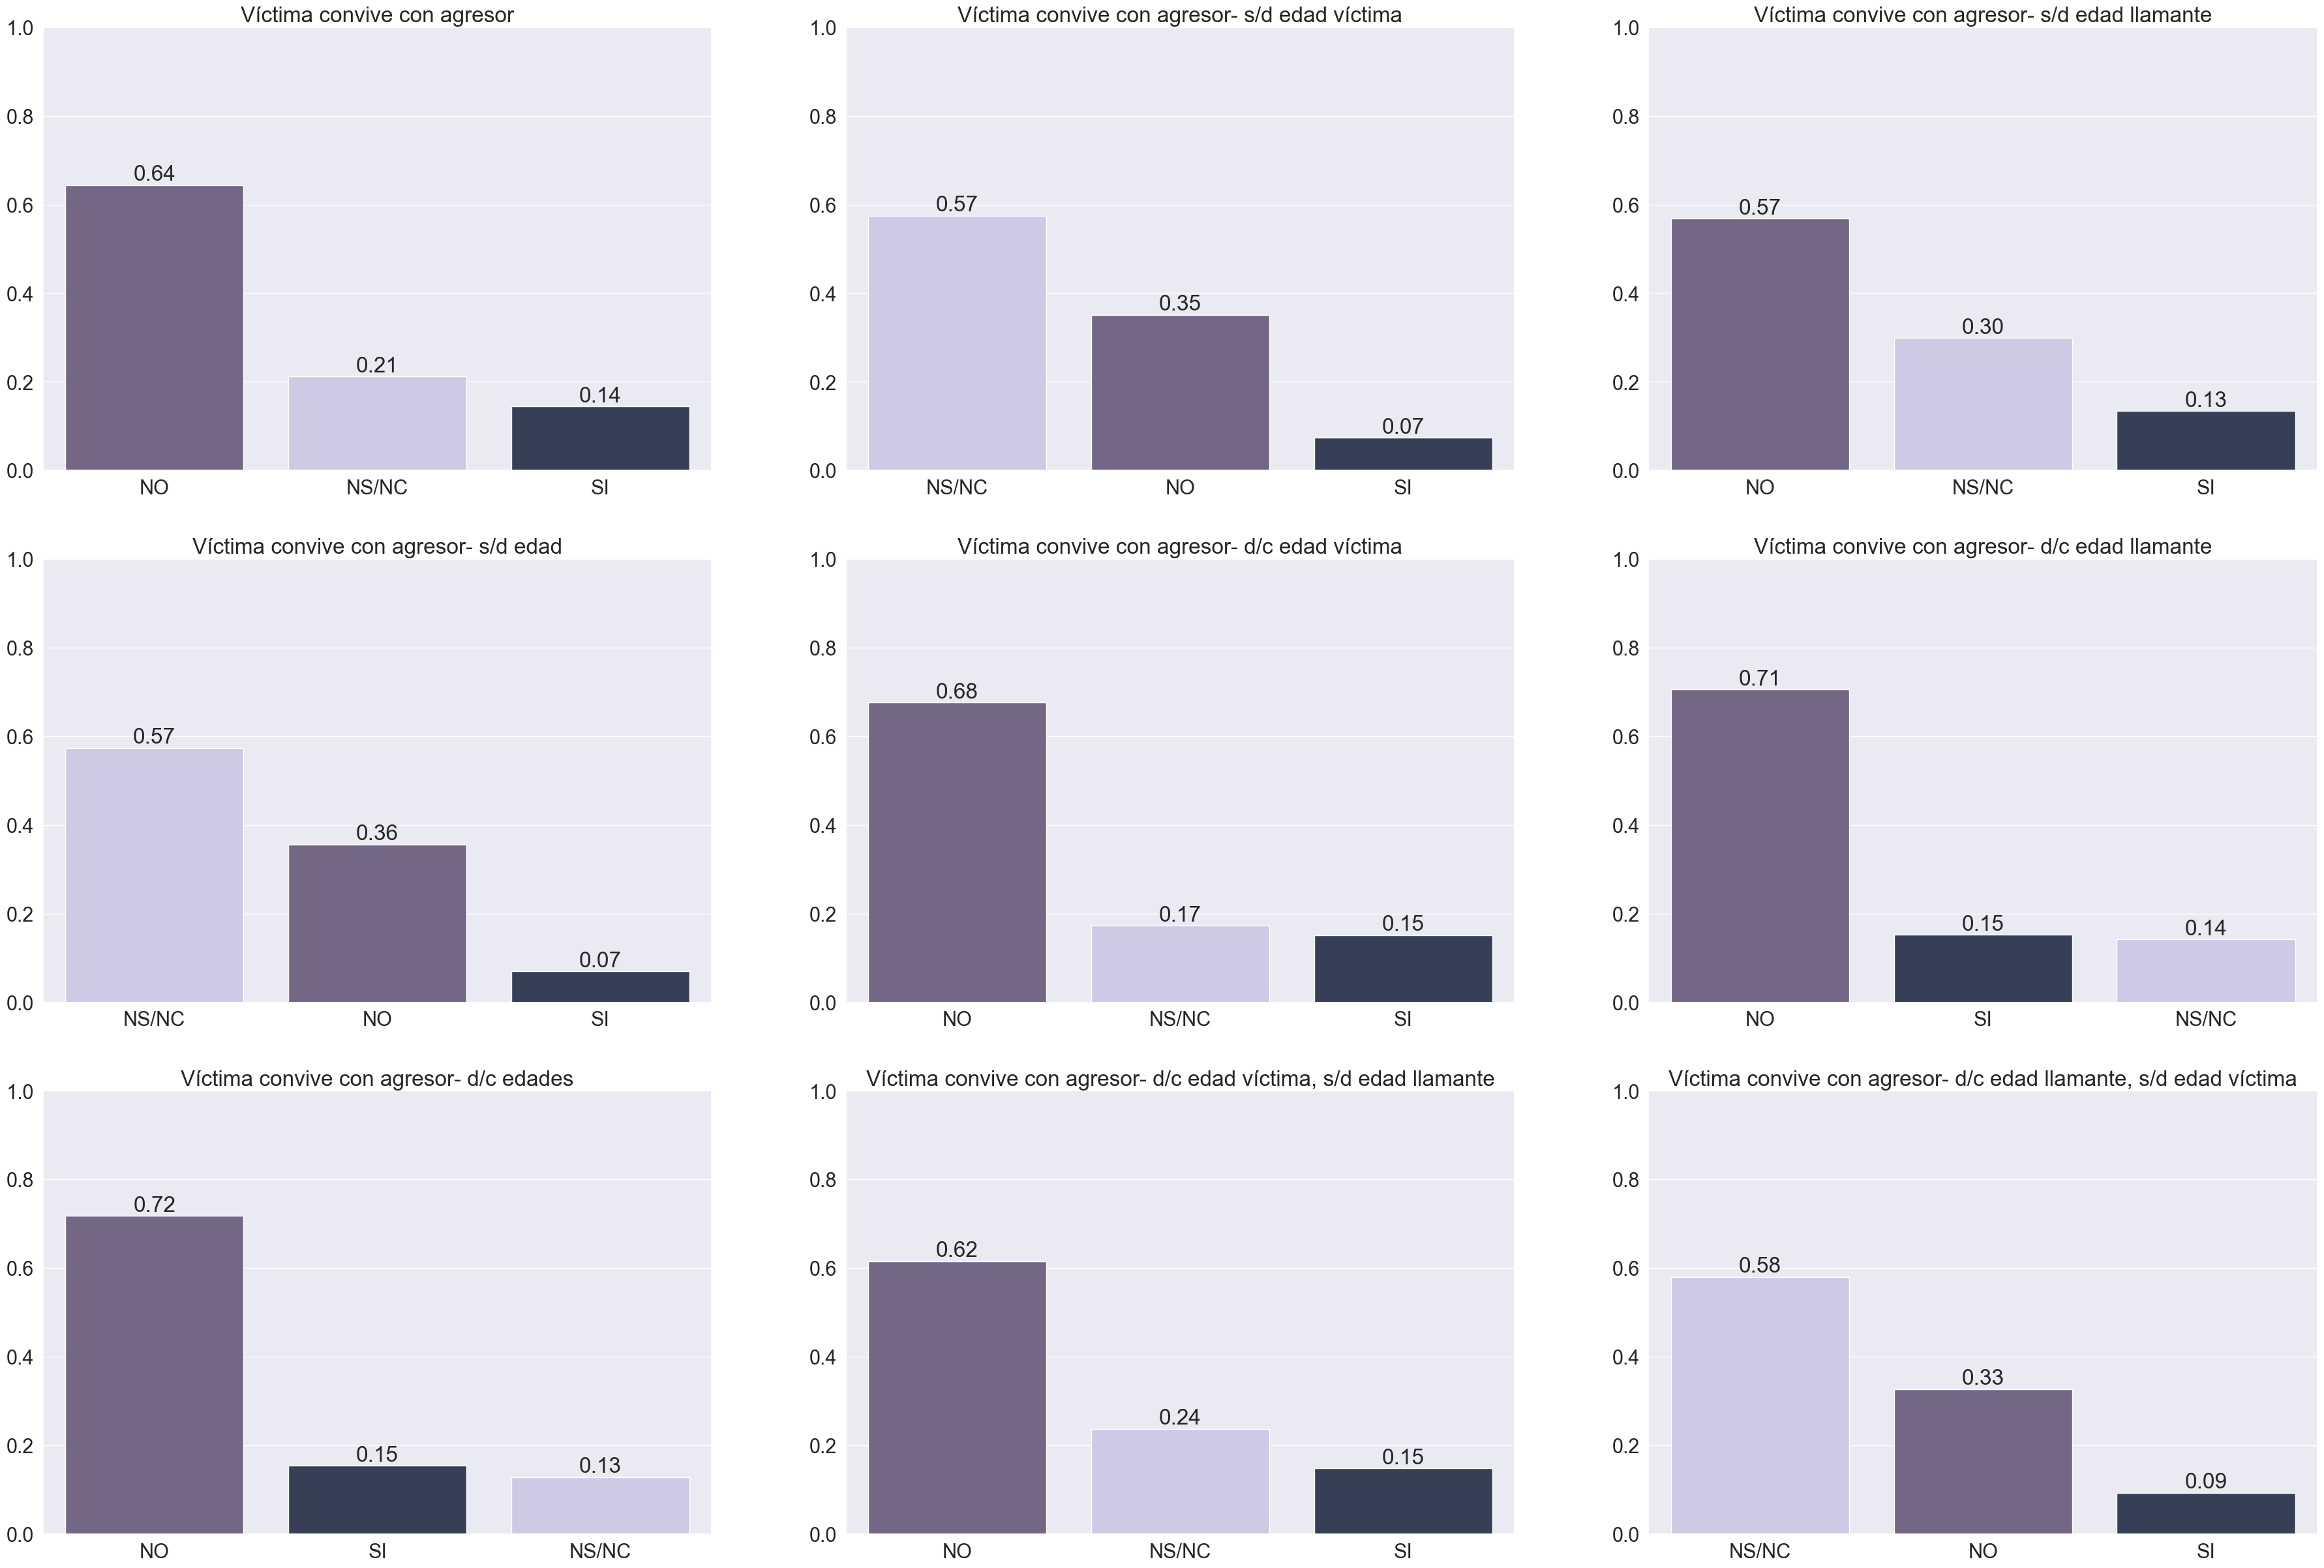

In [29]:
# graficar las diferencias de las variables en cada filtro 

# victima convive agresor

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))

# Plot the countplots with normalized values
sns.barplot(x=convive_llamados_counts.index, y=convive_llamados_counts.values, ax=ax[0, 0], palette=palette_sino)
ax[0, 0].set_title('Víctima convive con agresor')
ax[0, 0].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{convive_llamados_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



#############################################################    
    

sns.barplot(x=convive_null_victima_edad_counts.index, y=convive_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_sino)
ax[0, 1].set_title('Víctima convive con agresor- s/d edad víctima')
ax[0, 1].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{convive_null_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=convive_null_llamante_edad_counts.index, y=convive_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_sino)
ax[0, 2].set_title('Víctima convive con agresor- s/d edad llamante')
ax[0, 2].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{convive_null_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=convive_null_edades_counts.index, y=convive_null_edades_counts.values, ax=ax[1, 0], palette=palette_sino)
ax[1, 0].set_title('Víctima convive con agresor- s/d edad')
ax[1, 0].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{convive_null_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 

sns.barplot(x=convive_completo_victima_edad_counts.index, y=convive_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_sino)
ax[1, 1].set_title('Víctima convive con agresor- d/c edad víctima')
ax[1, 1].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{convive_completo_victima_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=convive_completo_llamante_edad_counts.index, y=convive_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_sino)
ax[1, 2].set_title('Víctima convive con agresor- d/c edad llamante')
ax[1, 2].set_xlabel('') 


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{convive_completo_llamante_edad_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 

sns.barplot(x=convive_completo_edades_counts.index, y=convive_completo_edades_counts.values, ax=ax[2, 0], palette=palette_sino)
ax[2, 0].set_title('Víctima convive con agresor- d/c edades')
ax[2, 0].set_xlabel('') 

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{convive_completo_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


sns.barplot(x=convive_v_lleno_ll_vacio_edades_counts.index, y=convive_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_sino)
ax[2, 1].set_title('Víctima convive con agresor- d/c edad víctima, s/d edad llamante')
ax[2, 1].set_xlabel('') 


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{convive_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 

sns.barplot(x=convive_v_vacio_ll_lleno_edades_counts.index, y=convive_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_sino)
ax[2, 2].set_title('Víctima convive con agresor- d/c edad llamante, s/d edad víctima')
ax[2, 2].set_xlabel('') 


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{convive_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')



############################################################# 


# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()


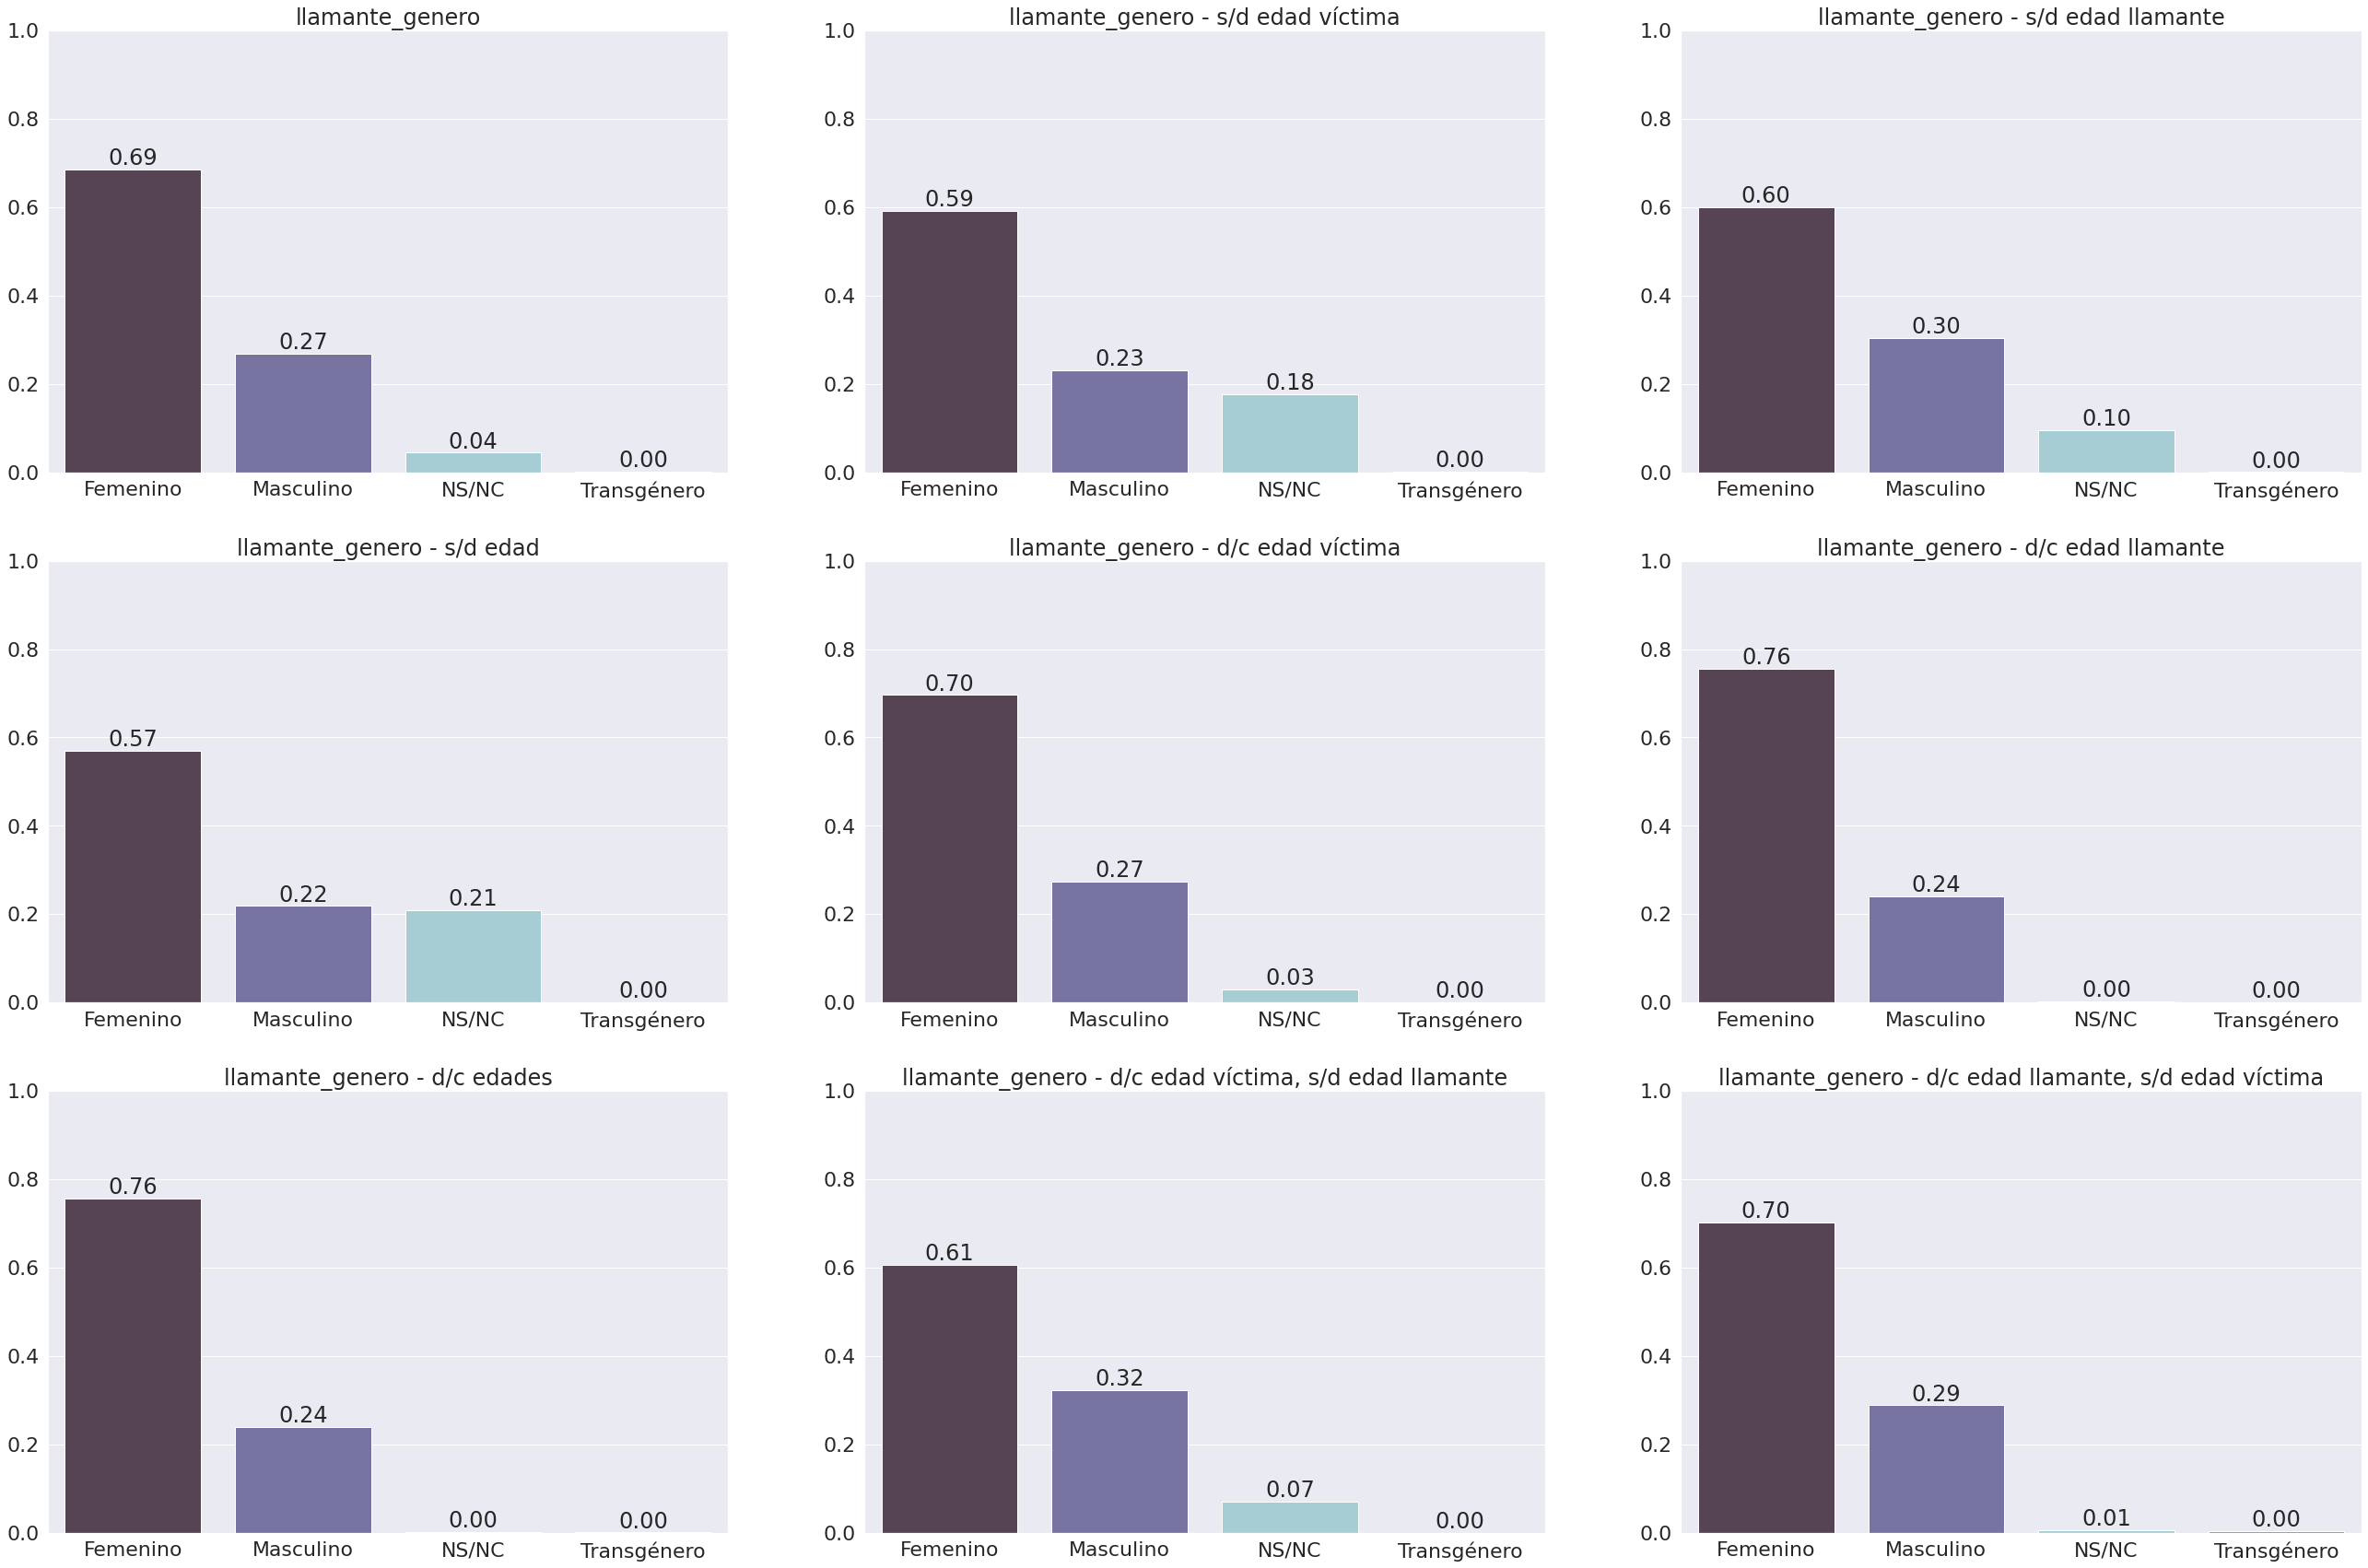

In [20]:
# graficar las diferencias de las variables en cada filtro 

# llamante genero

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))

# Plot the countplots with normalized values
sns.barplot(x=llgenero_llamados_counts.index, y=llgenero_llamados_counts.values, ax=ax[0, 0], palette=palette_gen)
ax[0, 0].set_title('llamante_genero')



# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{llgenero_llamados_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_null_victima_edad_counts.index, y=llgenero_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_gen)
ax[0, 1].set_title('llamante_genero - s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{llgenero_null_victima_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_null_llamante_edad_counts.index, y=llgenero_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_gen)
ax[0, 2].set_title('llamante_genero - s/d edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{llgenero_null_llamante_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################

sns.barplot(x=llgenero_null_edades_counts.index, y=llgenero_null_edades_counts.values, ax=ax[1, 0], palette=palette_gen)
ax[1, 0].set_title('llamante_genero - s/d edad')


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{llgenero_null_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_completo_victima_edad_counts.index, y=llgenero_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_gen)
ax[1, 1].set_title('llamante_genero - d/c edad víctima')



# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{llgenero_completo_victima_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_completo_llamante_edad_counts.index, y=llgenero_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_gen)
ax[1, 2].set_title('llamante_genero - d/c edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{llgenero_completo_llamante_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_completo_edades_counts.index, y=llgenero_completo_edades_counts.values, ax=ax[2, 0], palette=palette_gen)
ax[2, 0].set_title('llamante_genero - d/c edades')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{llgenero_completo_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_v_lleno_ll_vacio_edades_counts.index, y=llgenero_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_gen)
ax[2, 1].set_title('llamante_genero - d/c edad víctima, s/d edad llamante')

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{llgenero_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=llgenero_v_vacio_ll_lleno_edades_counts.index, y=llgenero_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_gen)
ax[2, 2].set_title('llamante_genero - d/c edad llamante, s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{llgenero_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()

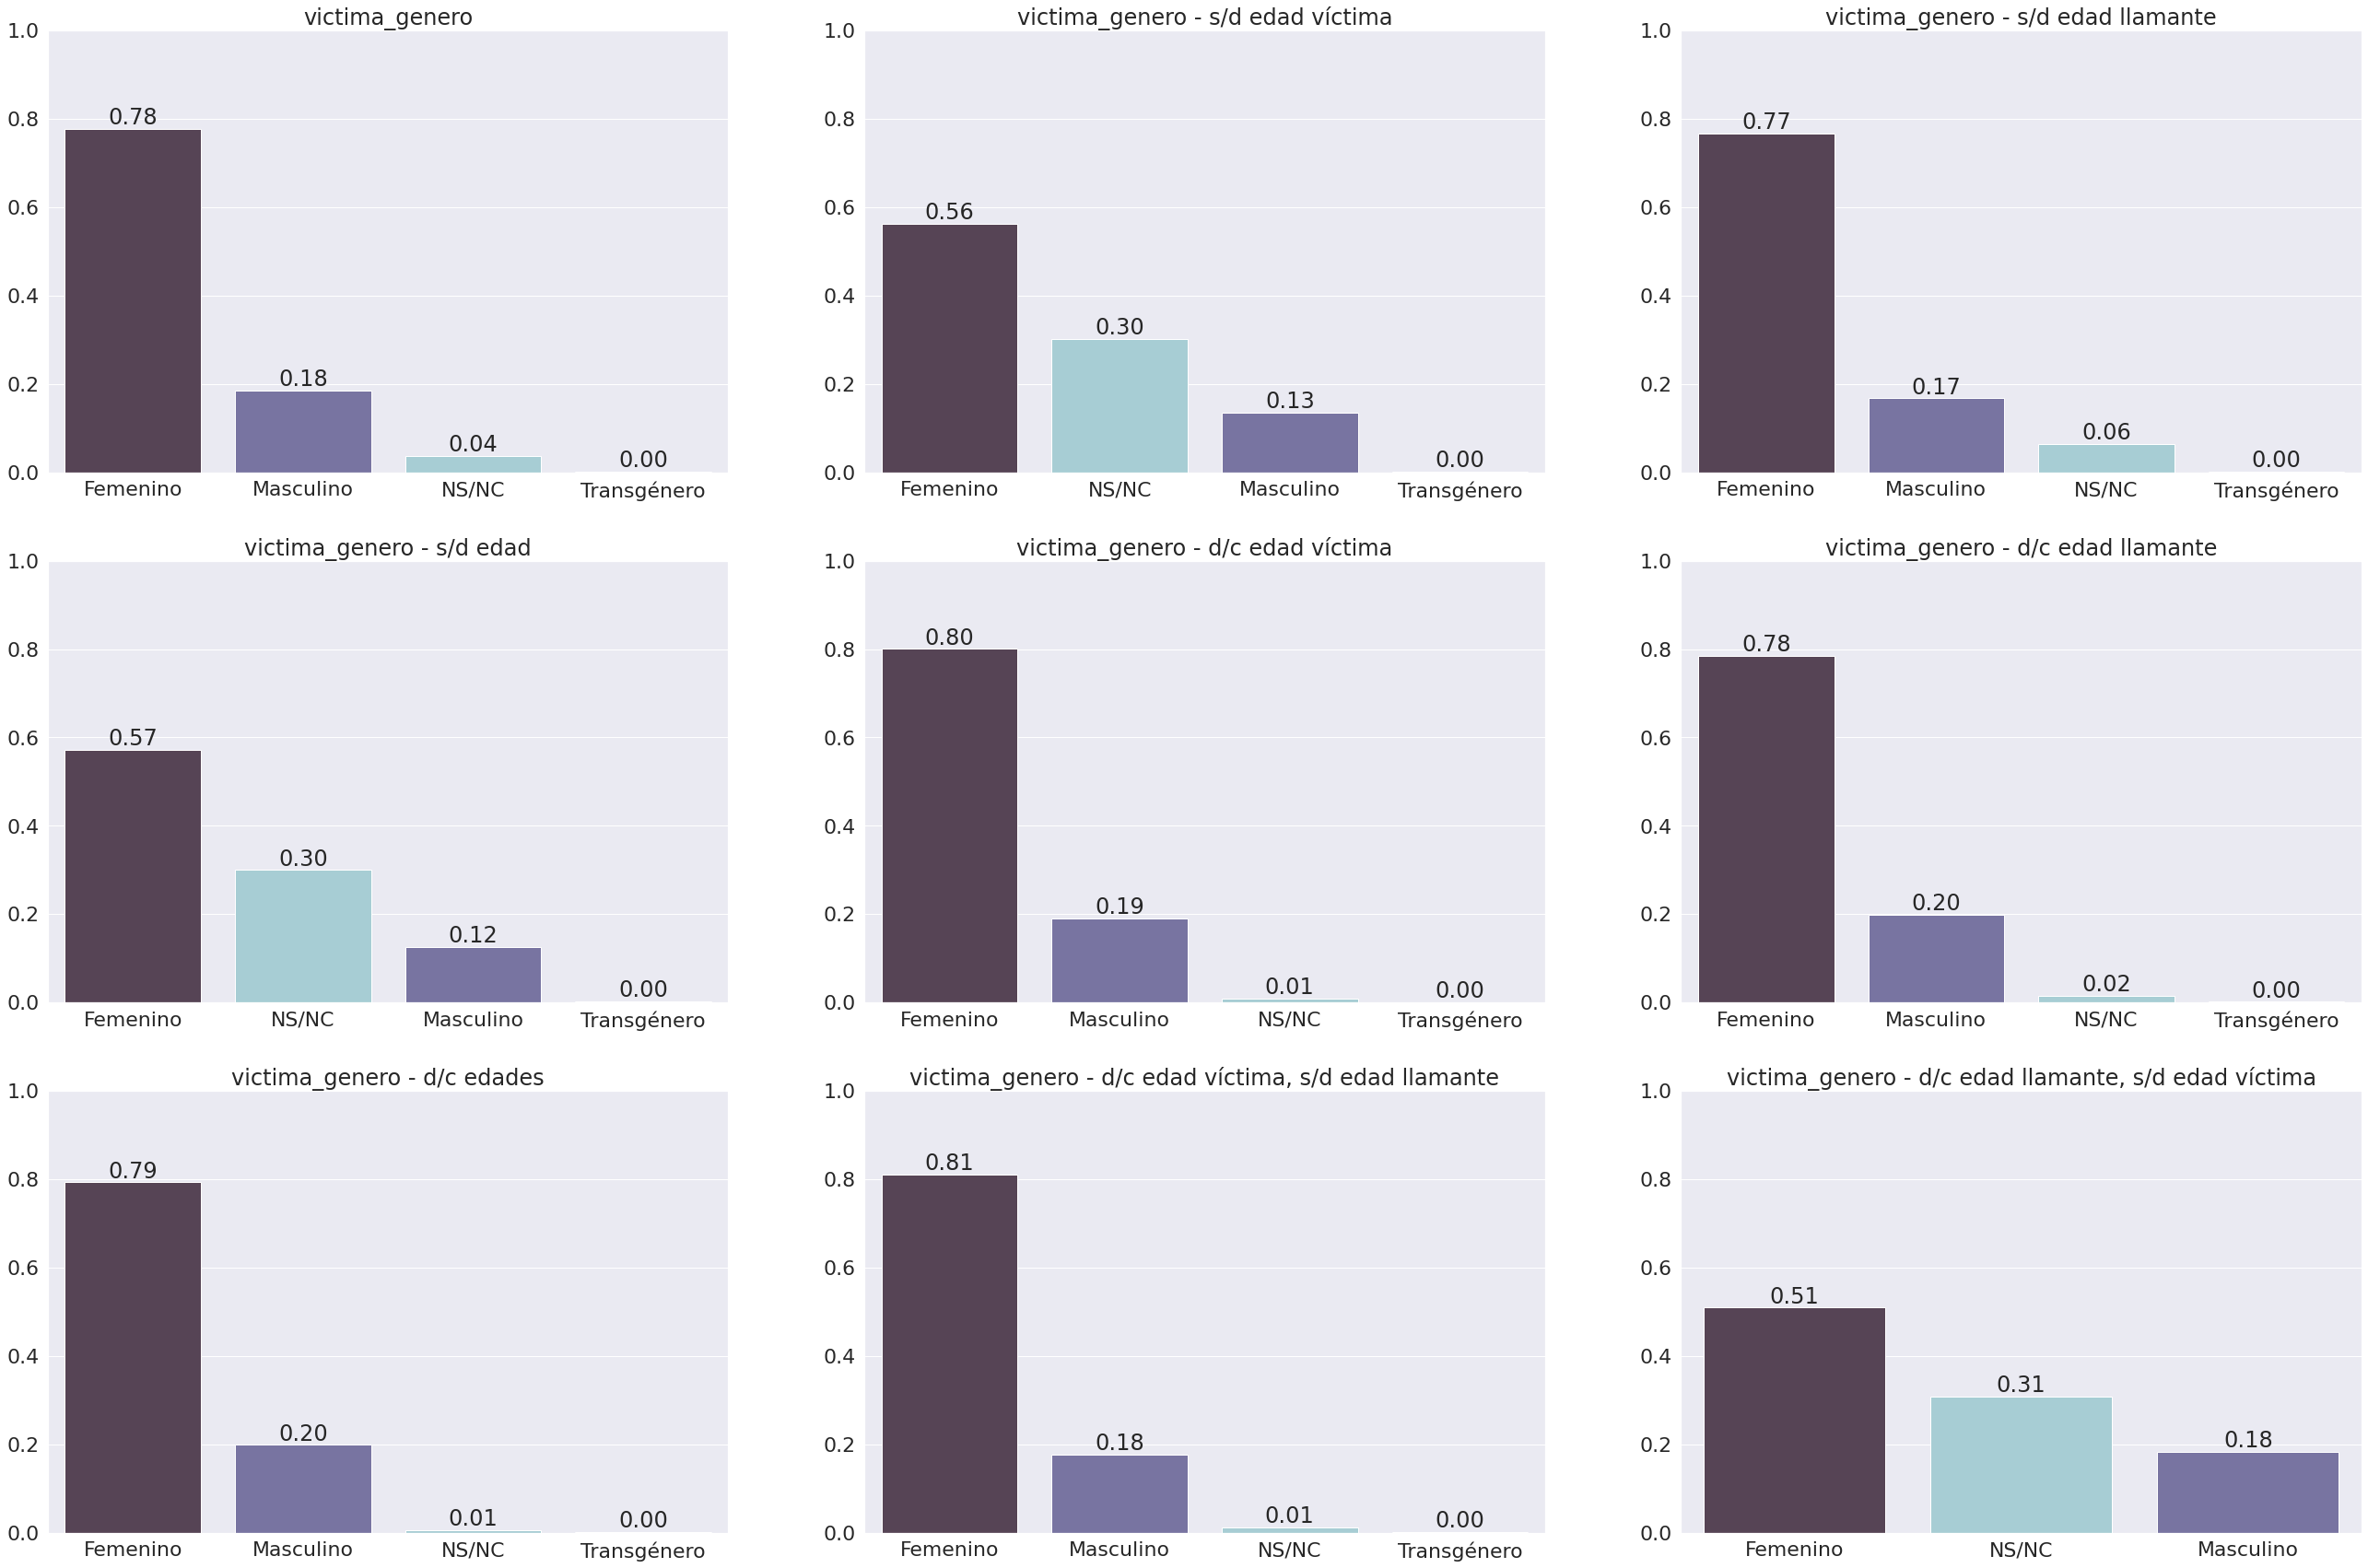

In [21]:
# graficar las diferencias de las variables en cada filtro 

# victima_genero

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))

# Plot the countplots with normalized values
sns.barplot(x=vgenero_llamados_counts.index, y=vgenero_llamados_counts.values, ax=ax[0, 0], palette=palette_gen)
ax[0, 0].set_title('victima_genero')



# Annotate bars with exact count values
for i, p in enumerate(ax[0, 0].patches):
    ax[0, 0].annotate(f'{vgenero_llamados_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_null_victima_edad_counts.index, y=vgenero_null_victima_edad_counts.values, ax=ax[0, 1], palette=palette_gen)
ax[0, 1].set_title('victima_genero - s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 1].patches):
    ax[0, 1].annotate(f'{vgenero_null_victima_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_null_llamante_edad_counts.index, y=vgenero_null_llamante_edad_counts.values, ax=ax[0, 2], palette=palette_gen)
ax[0, 2].set_title('victima_genero - s/d edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[0, 2].patches):
    ax[0, 2].annotate(f'{vgenero_null_llamante_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################

sns.barplot(x=vgenero_null_edades_counts.index, y=vgenero_null_edades_counts.values, ax=ax[1, 0], palette=palette_gen)
ax[1, 0].set_title('victima_genero - s/d edad')


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 0].patches):
    ax[1, 0].annotate(f'{vgenero_null_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_completo_victima_edad_counts.index, y=vgenero_completo_victima_edad_counts.values, ax=ax[1, 1], palette=palette_gen)
ax[1, 1].set_title('victima_genero - d/c edad víctima')



# Annotate bars with exact count values
for i, p in enumerate(ax[1, 1].patches):
    ax[1, 1].annotate(f'{vgenero_completo_victima_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_completo_llamante_edad_counts.index, y=vgenero_completo_llamante_edad_counts.values, ax=ax[1, 2], palette=palette_gen)
ax[1, 2].set_title('victima_genero - d/c edad llamante')


# Annotate bars with exact count values
for i, p in enumerate(ax[1, 2].patches):
    ax[1, 2].annotate(f'{vgenero_completo_llamante_edad_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_completo_edades_counts.index, y=vgenero_completo_edades_counts.values, ax=ax[2, 0], palette=palette_gen)
ax[2, 0].set_title('victima_genero - d/c edades')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 0].patches):
    ax[2, 0].annotate(f'{vgenero_completo_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_v_lleno_ll_vacio_edades_counts.index, y=vgenero_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], palette=palette_gen)
ax[2, 1].set_title('victima_genero - d/c edad víctima, s/d edad llamante')

# Annotate bars with exact count values
for i, p in enumerate(ax[2, 1].patches):
    ax[2, 1].annotate(f'{vgenero_v_lleno_ll_vacio_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################


sns.barplot(x=vgenero_v_vacio_ll_lleno_edades_counts.index, y=vgenero_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], palette=palette_gen)
ax[2, 2].set_title('victima_genero - d/c edad llamante, s/d edad víctima')


# Annotate bars with exact count values
for i, p in enumerate(ax[2, 2].patches):
    ax[2, 2].annotate(f'{vgenero_v_vacio_ll_lleno_edades_counts.values[i]:.2f}', 
                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')




#######################

# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])

# Display the plot
plt.show()

In [ ]:
# graficar las diferencias de las variables en cada filtro 

# victima vicnculo agresor

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))
fig.subplots_adjust(hspace=0.8)

# Plot the countplots with normalized values
sns.barplot(x=agvinculo_llamados_counts.index, y=agvinculo_llamados_counts.values, ax=ax[0, 0], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[0, 0].set_title('victima_vinculo_agresor')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)

sns.barplot(x=agvinculo_null_victima_edad_counts.index, y=agvinculo_null_victima_edad_counts.values, ax=ax[0, 1], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[0, 1].set_title('victima_vinculo_agresor - s/d edad víctima')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=90)



sns.barplot(x=agvinculo_null_llamante_edad_counts.index, y=agvinculo_null_llamante_edad_counts.values, ax=ax[0, 2], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[0, 2].set_title('victima_vinculo_agresor - s/d edad llamante')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=90)


sns.barplot(x=agvinculo_null_edades_counts.index, y=agvinculo_null_edades_counts.values, ax=ax[1, 0], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[1, 0].set_title('victima_vinculo_agresor - s/d edad')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=90)


sns.barplot(x=agvinculo_completo_victima_edad_counts.index, y=agvinculo_completo_victima_edad_counts.values, ax=ax[1, 1], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[1, 1].set_title('victima_vinculo_agresor - d/c edad víctima')
ax[1, 1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)


sns.barplot(x=agvinculo_completo_llamante_edad_counts.index, y=agvinculo_completo_llamante_edad_counts.values, ax=ax[1, 2], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[1, 2].set_title('victima_vinculo_agresor - d/c edad llamante')
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=90)


sns.barplot(x=agvinculo_completo_edades_counts.index, y=agvinculo_completo_edades_counts.values, ax=ax[2, 0], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[2, 0].set_title('victima_vinculo_agresor - d/c edades')
ax[2, 0].set_xticklabels(ax[2, 0].get_xticklabels(), rotation=90)


sns.barplot(x=agvinculo_v_lleno_ll_vacio_edades_counts.index, y=agvinculo_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[2, 1].set_title('victima_vinculo_agresor - d/c edad víctima, s/d edad llamante')
ax[2, 1].set_xticklabels(ax[2, 1].get_xticklabels(), rotation=90)


sns.barplot(x=agvinculo_v_vacio_ll_lleno_edades_counts.index, y=agvinculo_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], order=llamados['victima_vinculo_agresor'].value_counts().index)
ax[2, 2].set_title('victima_vinculo_agresor - d/c edad llamante, s/d edad víctima')
ax[2, 2].set_xticklabels(ax[2, 2].get_xticklabels(), rotation=90)


# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])



# Display the plot
plt.show()

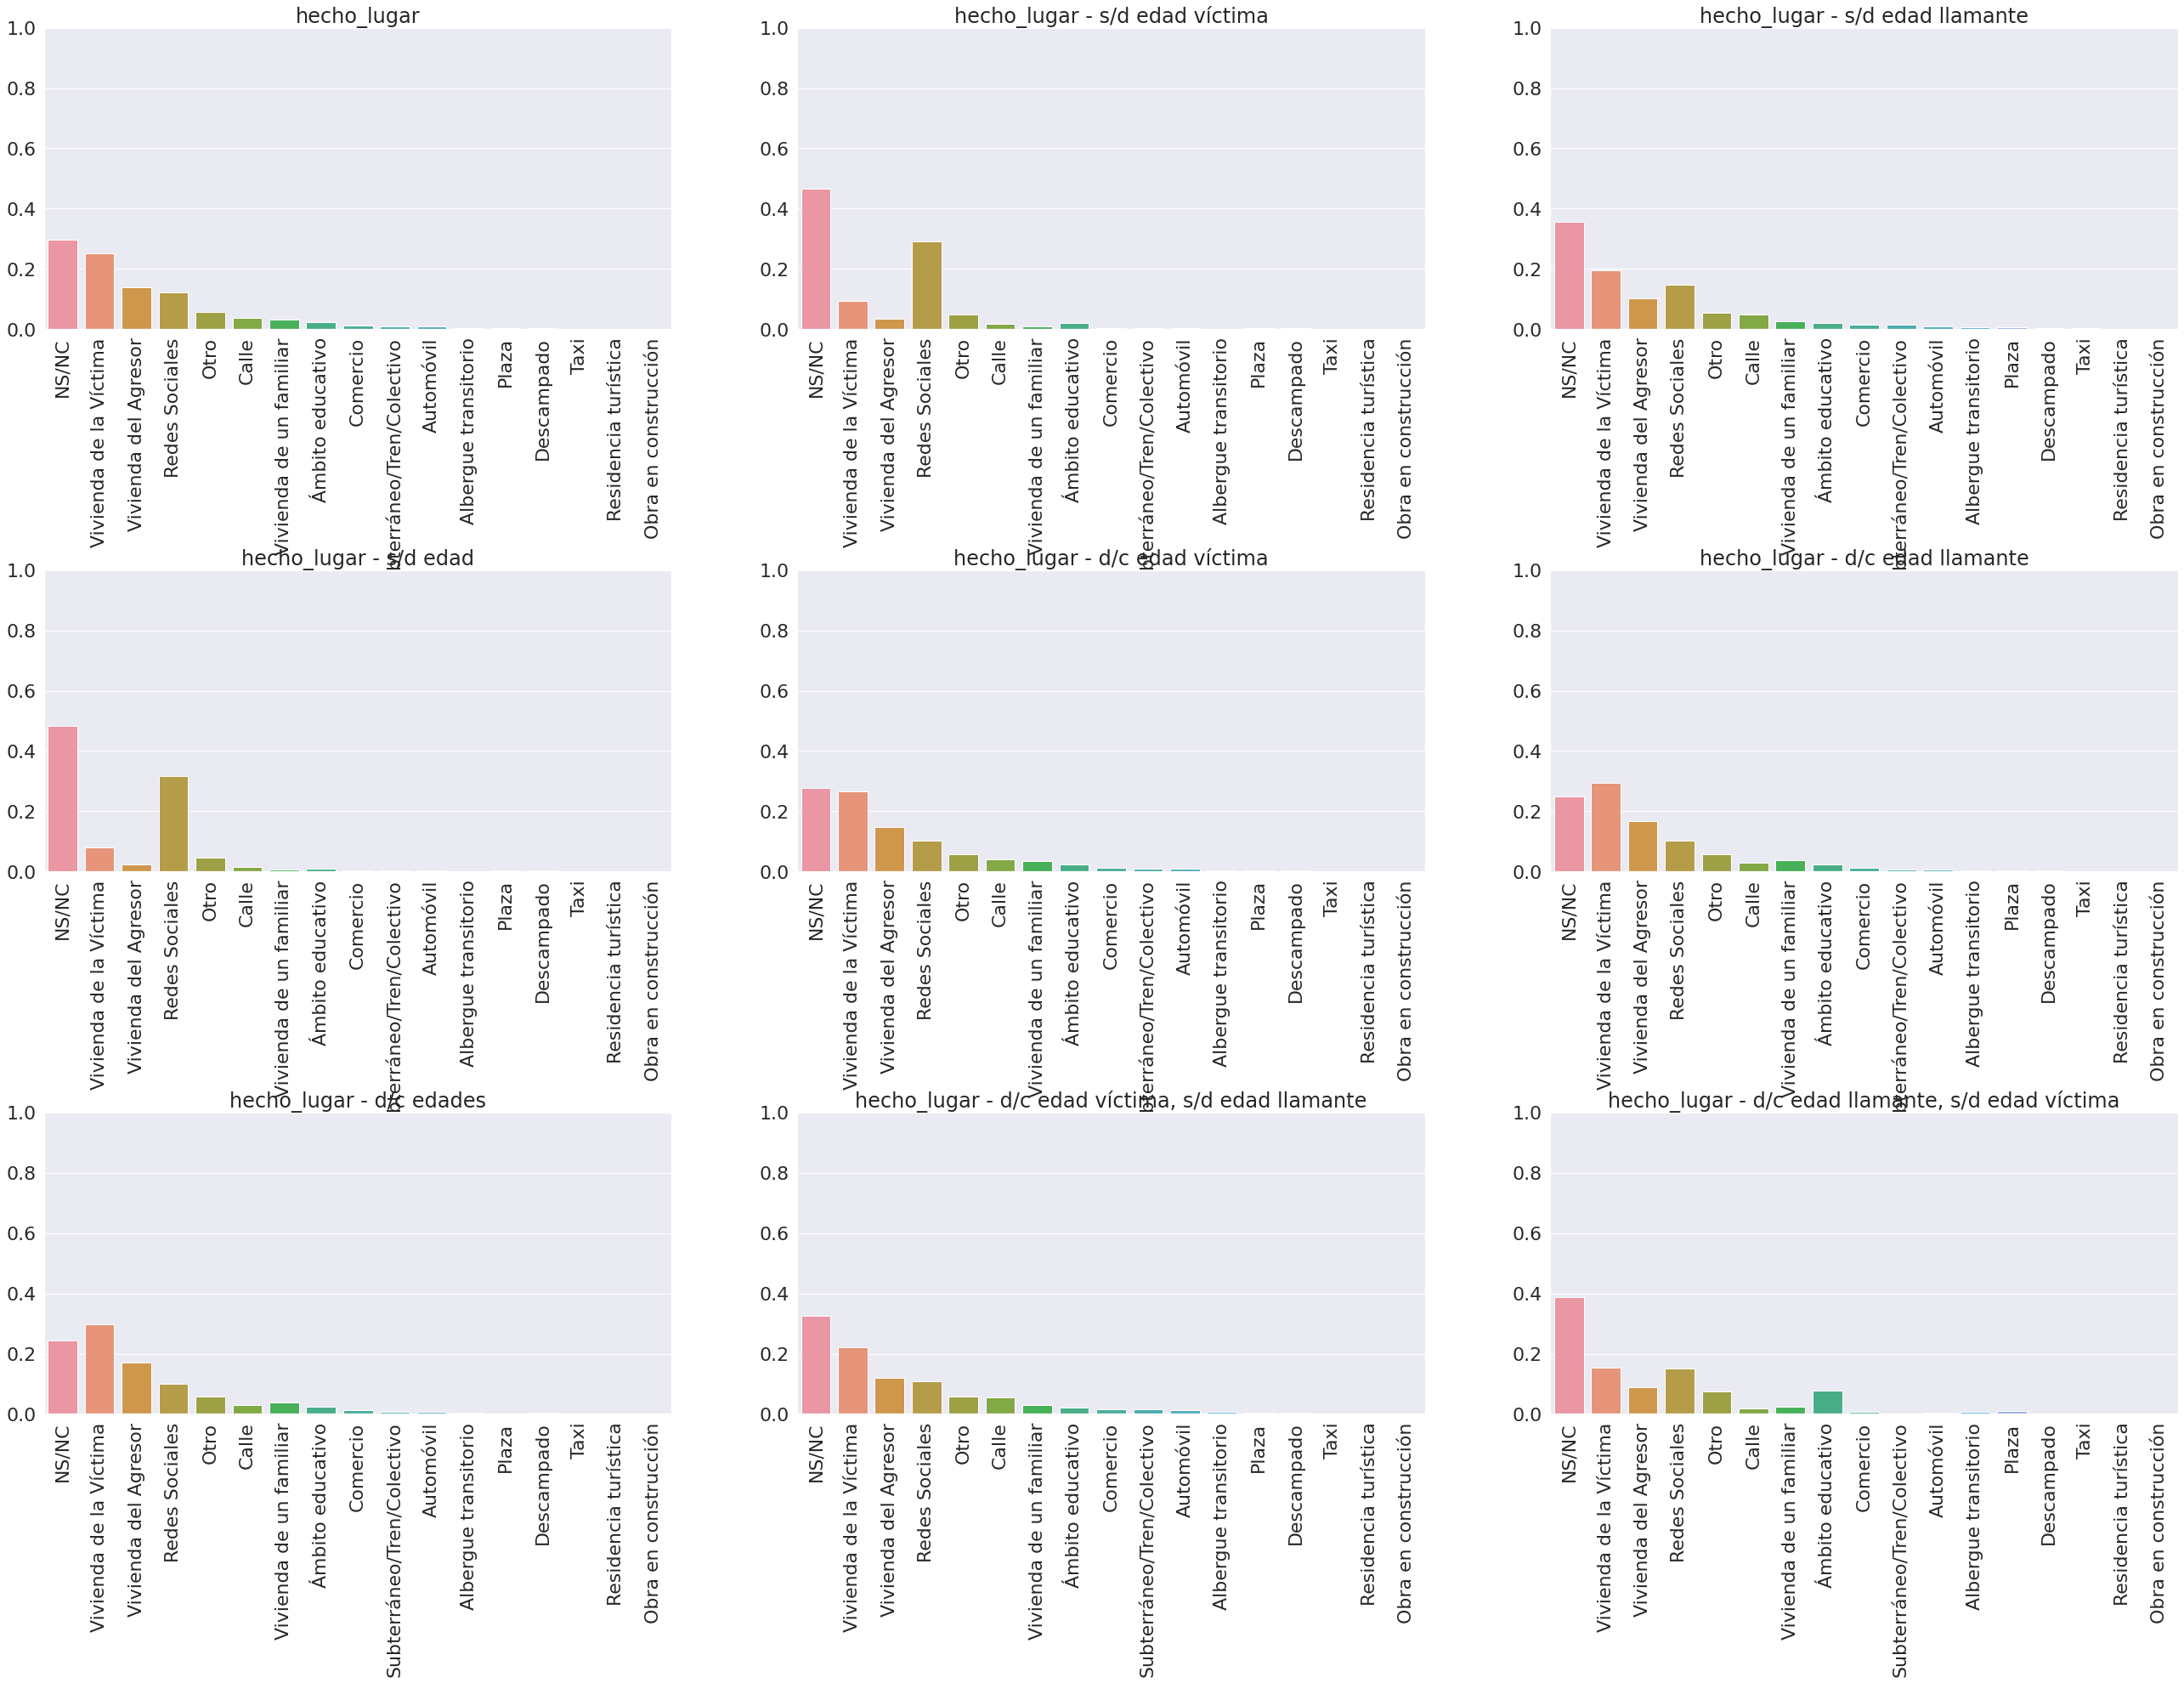

In [134]:
# graficar las diferencias de las variables en cada filtro 

# hecho lugar

# Set up the figure and axes

sns.set(font_scale=2)

fig, ax = plt.subplots(3, 3, figsize=(45, 30))
fig.subplots_adjust(hspace=0.8)

# Plot the countplots with normalized values
sns.barplot(x=lugar_llamados_counts.index, y=lugar_llamados_counts.values, ax=ax[0, 0], order=llamados['hecho_lugar'].value_counts().index)
ax[0, 0].set_title('hecho_lugar')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)

sns.barplot(x=lugar_null_victima_edad_counts.index, y=lugar_null_victima_edad_counts.values, ax=ax[0, 1], order=llamados['hecho_lugar'].value_counts().index)
ax[0, 1].set_title('hecho_lugar - s/d edad víctima')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=90)



sns.barplot(x=lugar_null_llamante_edad_counts.index, y=lugar_null_llamante_edad_counts.values, ax=ax[0, 2], order=llamados['hecho_lugar'].value_counts().index)
ax[0, 2].set_title('hecho_lugar - s/d edad llamante')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=90)


sns.barplot(x=lugar_null_edades_counts.index, y=lugar_null_edades_counts.values, ax=ax[1, 0], order=llamados['hecho_lugar'].value_counts().index)
ax[1, 0].set_title('hecho_lugar - s/d edad')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=90)


sns.barplot(x=lugar_completo_victima_edad_counts.index, y=lugar_completo_victima_edad_counts.values, ax=ax[1, 1], order=llamados['hecho_lugar'].value_counts().index)
ax[1, 1].set_title('hecho_lugar - d/c edad víctima')
ax[1, 1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)


sns.barplot(x=lugar_completo_llamante_edad_counts.index, y=lugar_completo_llamante_edad_counts.values, ax=ax[1, 2], order=llamados['hecho_lugar'].value_counts().index)
ax[1, 2].set_title('hecho_lugar - d/c edad llamante')
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=90)


sns.barplot(x=lugar_completo_edades_counts.index, y=lugar_completo_edades_counts.values, ax=ax[2, 0], order=llamados['hecho_lugar'].value_counts().index)
ax[2, 0].set_title('hecho_lugar - d/c edades')
ax[2, 0].set_xticklabels(ax[2, 0].get_xticklabels(), rotation=90)


sns.barplot(x=lugar_v_lleno_ll_vacio_edades_counts.index, y=lugar_v_lleno_ll_vacio_edades_counts.values, ax=ax[2, 1], order=llamados['hecho_lugar'].value_counts().index)
ax[2, 1].set_title('hecho_lugar - d/c edad víctima, s/d edad llamante')
ax[2, 1].set_xticklabels(ax[2, 1].get_xticklabels(), rotation=90)


sns.barplot(x=lugar_v_vacio_ll_lleno_edades_counts.index, y=lugar_v_vacio_ll_lleno_edades_counts.values, ax=ax[2, 2], order=llamados['hecho_lugar'].value_counts().index)
ax[2, 2].set_title('hecho_lugar - d/c edad llamante, s/d edad víctima')
ax[2, 2].set_xticklabels(ax[2, 2].get_xticklabels(), rotation=90)


# Set y-axis limits to [0, 1]
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 1])



# Display the plot
plt.show()

### Asignación de -1 a nulos de edad

Asignar -1 a los valores nulos en las columnas de edad para por poder tirar pairplots y ver si hay algo ahí



In [62]:
# creo las columnas copiadas a las que le voy a asignar los negativos

llamados['victima_edad_neg'] = llamados['victima_edad']
llamados['llamante_edad_neg'] = llamados['llamante_edad']
llamados.fillna({"llamante_edad_neg": -5, "victima_edad_neg": -5}, inplace=True)


In [46]:
llamados.columns

Index(['llamado_fecha_hora', 'llamado_provincia', 'llamante_edad',
       'llamante_genero', 'llamante_vinculo', 'caso_judicializado',
       'hecho_lugar', 'victima_a_resguardo', 'victima_edad', 'victima_genero',
       'victima_nacionalidad', 'victima_vinculo_agresor',
       'victima_discapacidad', 'victima_convive_agresor',
       'vs_tentativa_violacion', 'vs_tocamiento_sexual',
       'vs_intento_tocamiento', 'vs_Intento_violación_tercera_persona',
       'vs_grooming', 'vs_exhibicionismo',
       'vs_amenazas_verbales_contenido_sexual',
       'vs_existencia_facilitador_corrupcion_nnya',
       'vs_obligacion_sacarse_fotos_pornograficas',
       'vs_eyaculacion_partes_cuerpo', 'vs_acoso_sexual',
       'vs_iniciacion_sexual_forzada_inducida',
       'vs_otra_forma_violencia_sexual', 'vs_no_sabe_no_contesta',
       'ofv_sentimiento_amenaza', 'ofv_amenaza_explicita',
       'ofv_violencia_fisica', 'ofv_amenaza_muerte',
       'ofv_uso_sustancias_psicoactivas', 'ofv_intento_privac

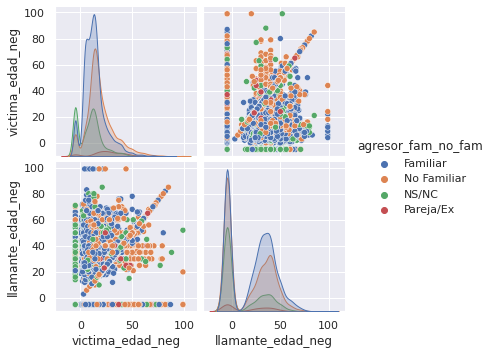

In [68]:
sns.set(font_scale=1)

ffigsize=(50, 60)


sns.pairplot(llamados[['victima_edad_neg', 'llamante_edad_neg','agresor_fam_no_fam']], hue = "agresor_fam_no_fam")

plt.show()

In [ ]:
llamados.agresor_conocido_no_conocido

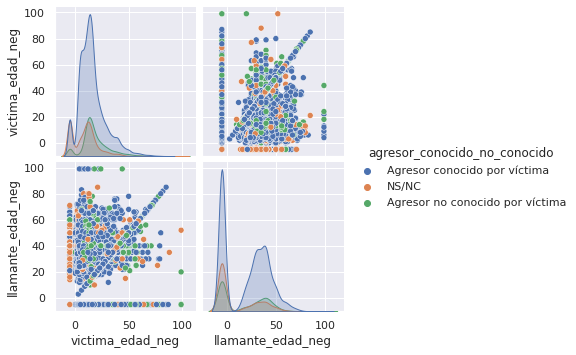

In [69]:
sns.set(font_scale=1)

ffigsize=(50, 60)


sns.pairplot(llamados[['victima_edad_neg', 'llamante_edad_neg','agresor_conocido_no_conocido']], hue = "agresor_conocido_no_conocido")

plt.show()

## Medidas descriptivas de edad: centralidad, dispersión y posición


### Centralidad
- media
- mediana --> robusta
- moda --> robusta


### Dispersión

- rango intercuartílico --> robusto
- MAD --> no sé si es robusta pero trabaja con la mediana

### Posición

- cuartiles

### Otras medidas para caracterizar la distribución

- Coeficiente de asimetría de Bowley: 
toma como referencia los cuartiles para determinar si la distribución es simétrica o no, focalizando en el 50% de los valores centrales de la distribución.Se utiliza en general cuando la media y el desvío estándar no son representativos del conjunto de observaciones.

Descarto:
- rango muestral
- varianza muestral
- desviación estándar muestral
- desviación muestral estándar

Todas se van a ver afectadas por los datos faltantes.

In [50]:
def asimetria_bowley(data):
     return (data.quantile(0.75)-2*data.quantile(0.50)
             +data.quantile(0.25))/(data.quantile(0.75)
                                    -data.quantile(0.25))
    


In [51]:
asimetria_bowley(llamados.llamante_edad)

0.07692307692307693

In [61]:
llamados.llamante_edad.mode().round(2)[0]


40.0

In [63]:
columnas = {'estadístico': ['media', 'mediana', 'moda','25', '50', '75','iqr', 'mad', 'asimetría de Bowley'],
           'llamante_edad': [llamados.llamante_edad.mean().round(2),llamados.llamante_edad.median().round(2),
                            llamados.llamante_edad.mode().round(2)[0],llamados.llamante_edad.quantile(0.25),
                            llamados.llamante_edad.quantile(0.50), llamados.llamante_edad.quantile(0.75),
                            llamados.llamante_edad.quantile(0.75)-llamados.llamante_edad.quantile(0.25),
                            llamados.llamante_edad.mad().round(2), 
                             asimetria_bowley(llamados.llamante_edad).round(2)],
           'victima_edad': [llamados.victima_edad.mean().round(2),llamados.victima_edad.median().round(2),
                            llamados.victima_edad.mode().round(2)[0],llamados.victima_edad.quantile(0.25),
                            llamados.victima_edad.quantile(0.50), llamados.victima_edad.quantile(0.75),
                            llamados.victima_edad.quantile(0.75)-llamados.victima_edad.quantile(0.25),
                            llamados.victima_edad.mad().round(2), 
                             asimetria_bowley(llamados.victima_edad).round(2)]}

descripcion = pd.DataFrame(columnas, columns = ['estadístico', 'llamante_edad', 'victima_edad'])






descripcion

,estadístico,llamante_edad,victima_edad
0,media,36.25,17.17
1,mediana,35.00,14.00
2,moda,40.00,14.00
3,25,29.00,10.00
4,50,35.00,14.00
5,75,42.00,21.00
6,iqr,13.00,11.00
7,mad,8.90,8.70
8,asimetría de Bowley,0.08,0.27


## Imputaciones

### Hot deck


In [86]:
columnas_test = {'uno': ['a','b','c','a'],
           'dos': [1,13,45,3],
           'tres': [1,2,43,2],
                'cuatro': ['a','c','c','a'],
                'cinco': ['a','b','c','b'],
                'seis':[4,1,2,4],
            'siete': ['b','c', 'a', 'b']}

test = pd.DataFrame(columnas_test, columns = ['uno', 'dos', 'tres','cuatro','cinco', 'seis','siete'])

test


,uno,dos,tres,cuatro,cinco,seis,siete
0,a,1,1,a,a,4,b
1,b,13,2,c,b,1,c
2,c,45,43,c,c,2,a
3,a,3,2,a,b,4,b


In [87]:
import gower
gower_data = gower.gower_matrix(test)
gower_data

array([[0.        , 0.7566481 , 0.95238096, 0.15275201],
       [0.7566481 , 0.        , 0.7195424 , 0.6038961 ],
       [0.95238096, 0.7195424 , 0.        , 0.9424861 ],
       [0.15275201, 0.6038961 , 0.9424861 , 0.        ]], dtype=float32)

In [92]:
row_mins = np.where(np.eye(*gower_data.shape, dtype=bool), gower_data.max(), gower_data).min(axis=1)
row_mins


array([0.15275201, 0.6038961 , 0.7195424 , 0.15275201], dtype=float32)

In [89]:
similar_row = {}
for row in gower_data:
    for i in row:
        print(i)

0.0
0.7566481
0.95238096
0.15275201
0.7566481
0.0
0.7195424
0.6038961
0.95238096
0.7195424
0.0
0.9424861
0.15275201
0.6038961
0.9424861
0.0
